### 참고사항
 - 다중공성선 제거 방법 : regularization


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))
pd.set_option("display.max_columns", 55)

In [28]:
df2 = pd.read_csv('./test_0407.csv')

Text(0.5, 1.0, '시즌별 연봉 중앙값')

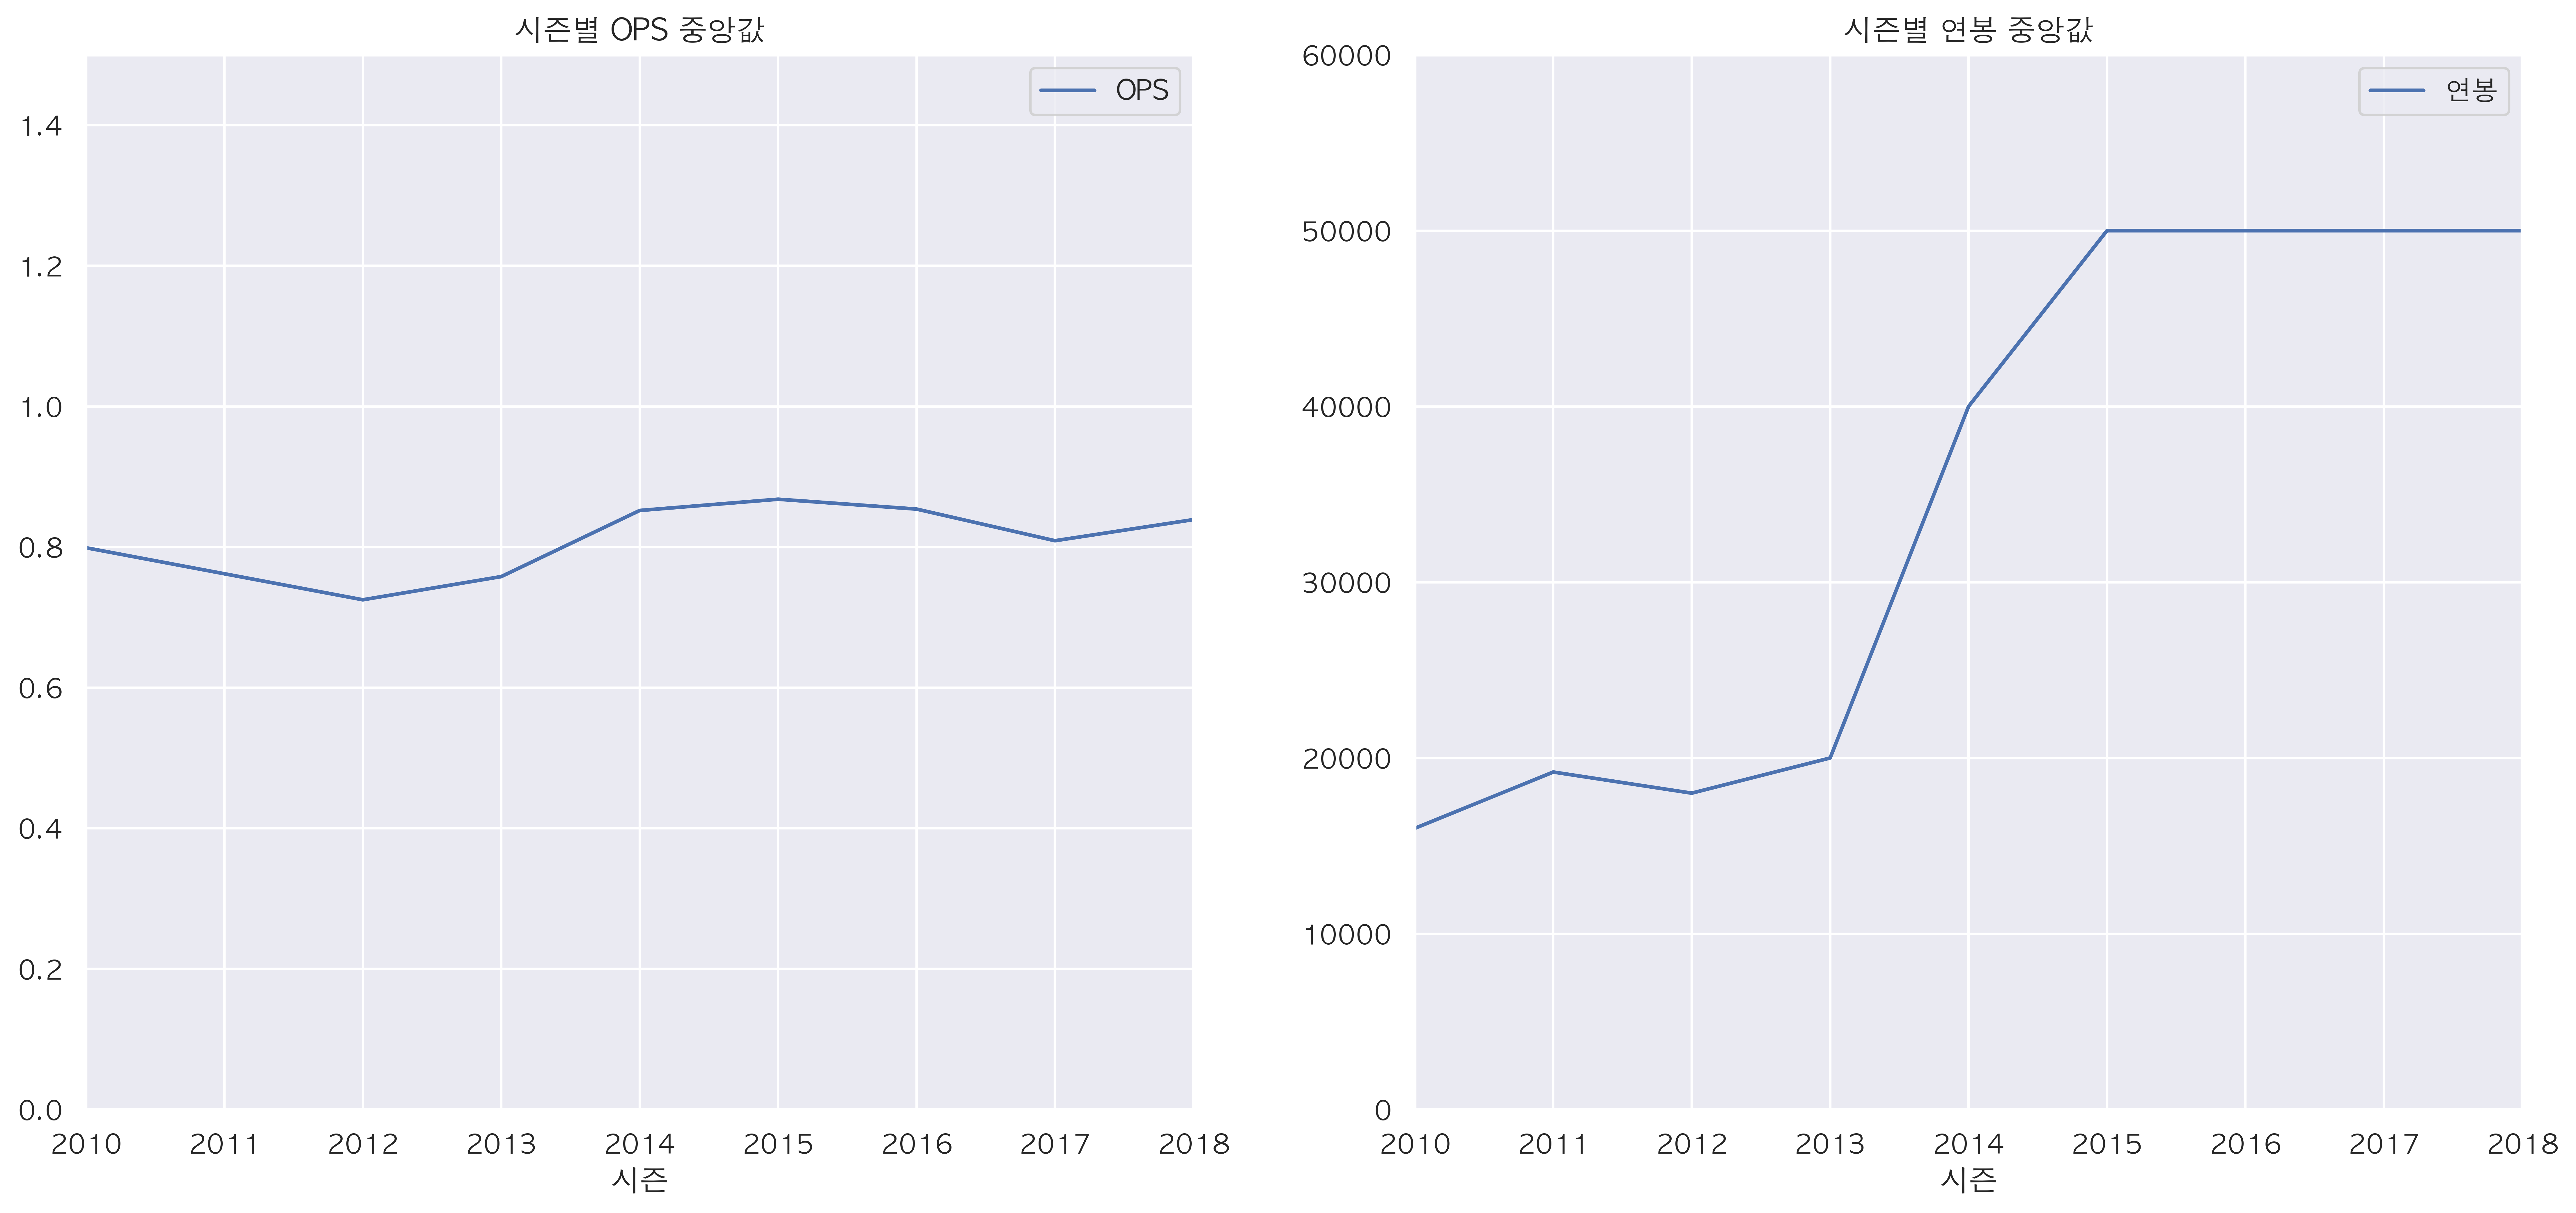

In [25]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df1[['시즌', 'OPS']].groupby('시즌').median().plot(ax=ax[0])
ax[0].set_ylim(0, 1.5)
ax[0].set_title('시즌별 OPS 중앙값')
df1[['시즌', '연봉']].groupby('시즌').median().plot(ax=ax[1])
ax[1].set_ylim(0, 60000)
ax[1].set_title('시즌별 연봉 중앙값')

In [29]:
df2['시즌C'] = df2.시즌.apply(lambda x: 0 if x <= 2013 else x)
df2['시즌C'] = df2.시즌C.apply(lambda x: 1 if x == 2014 else x)
df2['시즌C'] = df2.시즌C.apply(lambda x: 2 if x > 2014 else x)

In [30]:
df2['경험N'] = df2['시즌'] - df2['데뷔']

In [31]:
#train = df[df.시즌 <= 2017]
#test = df[df.시즌 == 2018]

In [32]:
import re
names = df.이름.unique()
df2['외국인'] = None
for name in names:
    if re.findall('[에, 브, 워, 대, 피, 히, 버, 러, 칸, 루, 필, 파, 스, 아,마, 가, 초, 모, 로, 발, 번, 테, 호]', name[0]):
        df2['외국인'][df2['이름'] == name] = 1
    else:
        df2['외국인'][df2['이름'] == name] = 0

In [33]:
df2['BABIP'] = (df2['안타'] - df2['홈런']) / \
    (df2['타수'] - df2['삼진']-df2['홈런'] - df2['희비'])

In [34]:
a = ['나바로', '조쉬벨', '고메즈']
for name in a:
    df2['외국인'][df2['이름'] == name] = 1

In [35]:
df2['이적'] = None
for x in df2['이름']:
    df2['이적'][df2['이름'] == x] = len(df2[df2['이름'] == x]['팀'].unique()) - 1

In [36]:
df2['이적C'] = df2.이적.apply(lambda x: 0 if x <= 2 else x)
df2['이적C'] = df2.이적C.apply(lambda x: 1 if x > 2 else x)
#df['이적C'] = df.이적C.apply(lambda x: 2 if x >= 3 else x)
#df['이적C'] = df.이적C.apply(lambda x: 3 if x >= 3 else x)

In [37]:
df2['나이C'] = df2.나이.apply(lambda x: 0 if x <= 23 else x)
df2['나이C'] = df2.나이C.apply(lambda x: 1 if 26 >= x > 23 else x)
df2['나이C'] = df2.나이C.apply(lambda x: 2 if 33 >= x > 26 else x)
df2['나이C'] = df2.나이C.apply(lambda x: 3 if 37 >= x > 33 else x)
df2['나이C'] = df2.나이C.apply(lambda x: 4 if 40 >= x > 37 else x)
df2['나이C'] = df2.나이C.apply(lambda x: 5 if x >= 40 else x)

(0, 46000)

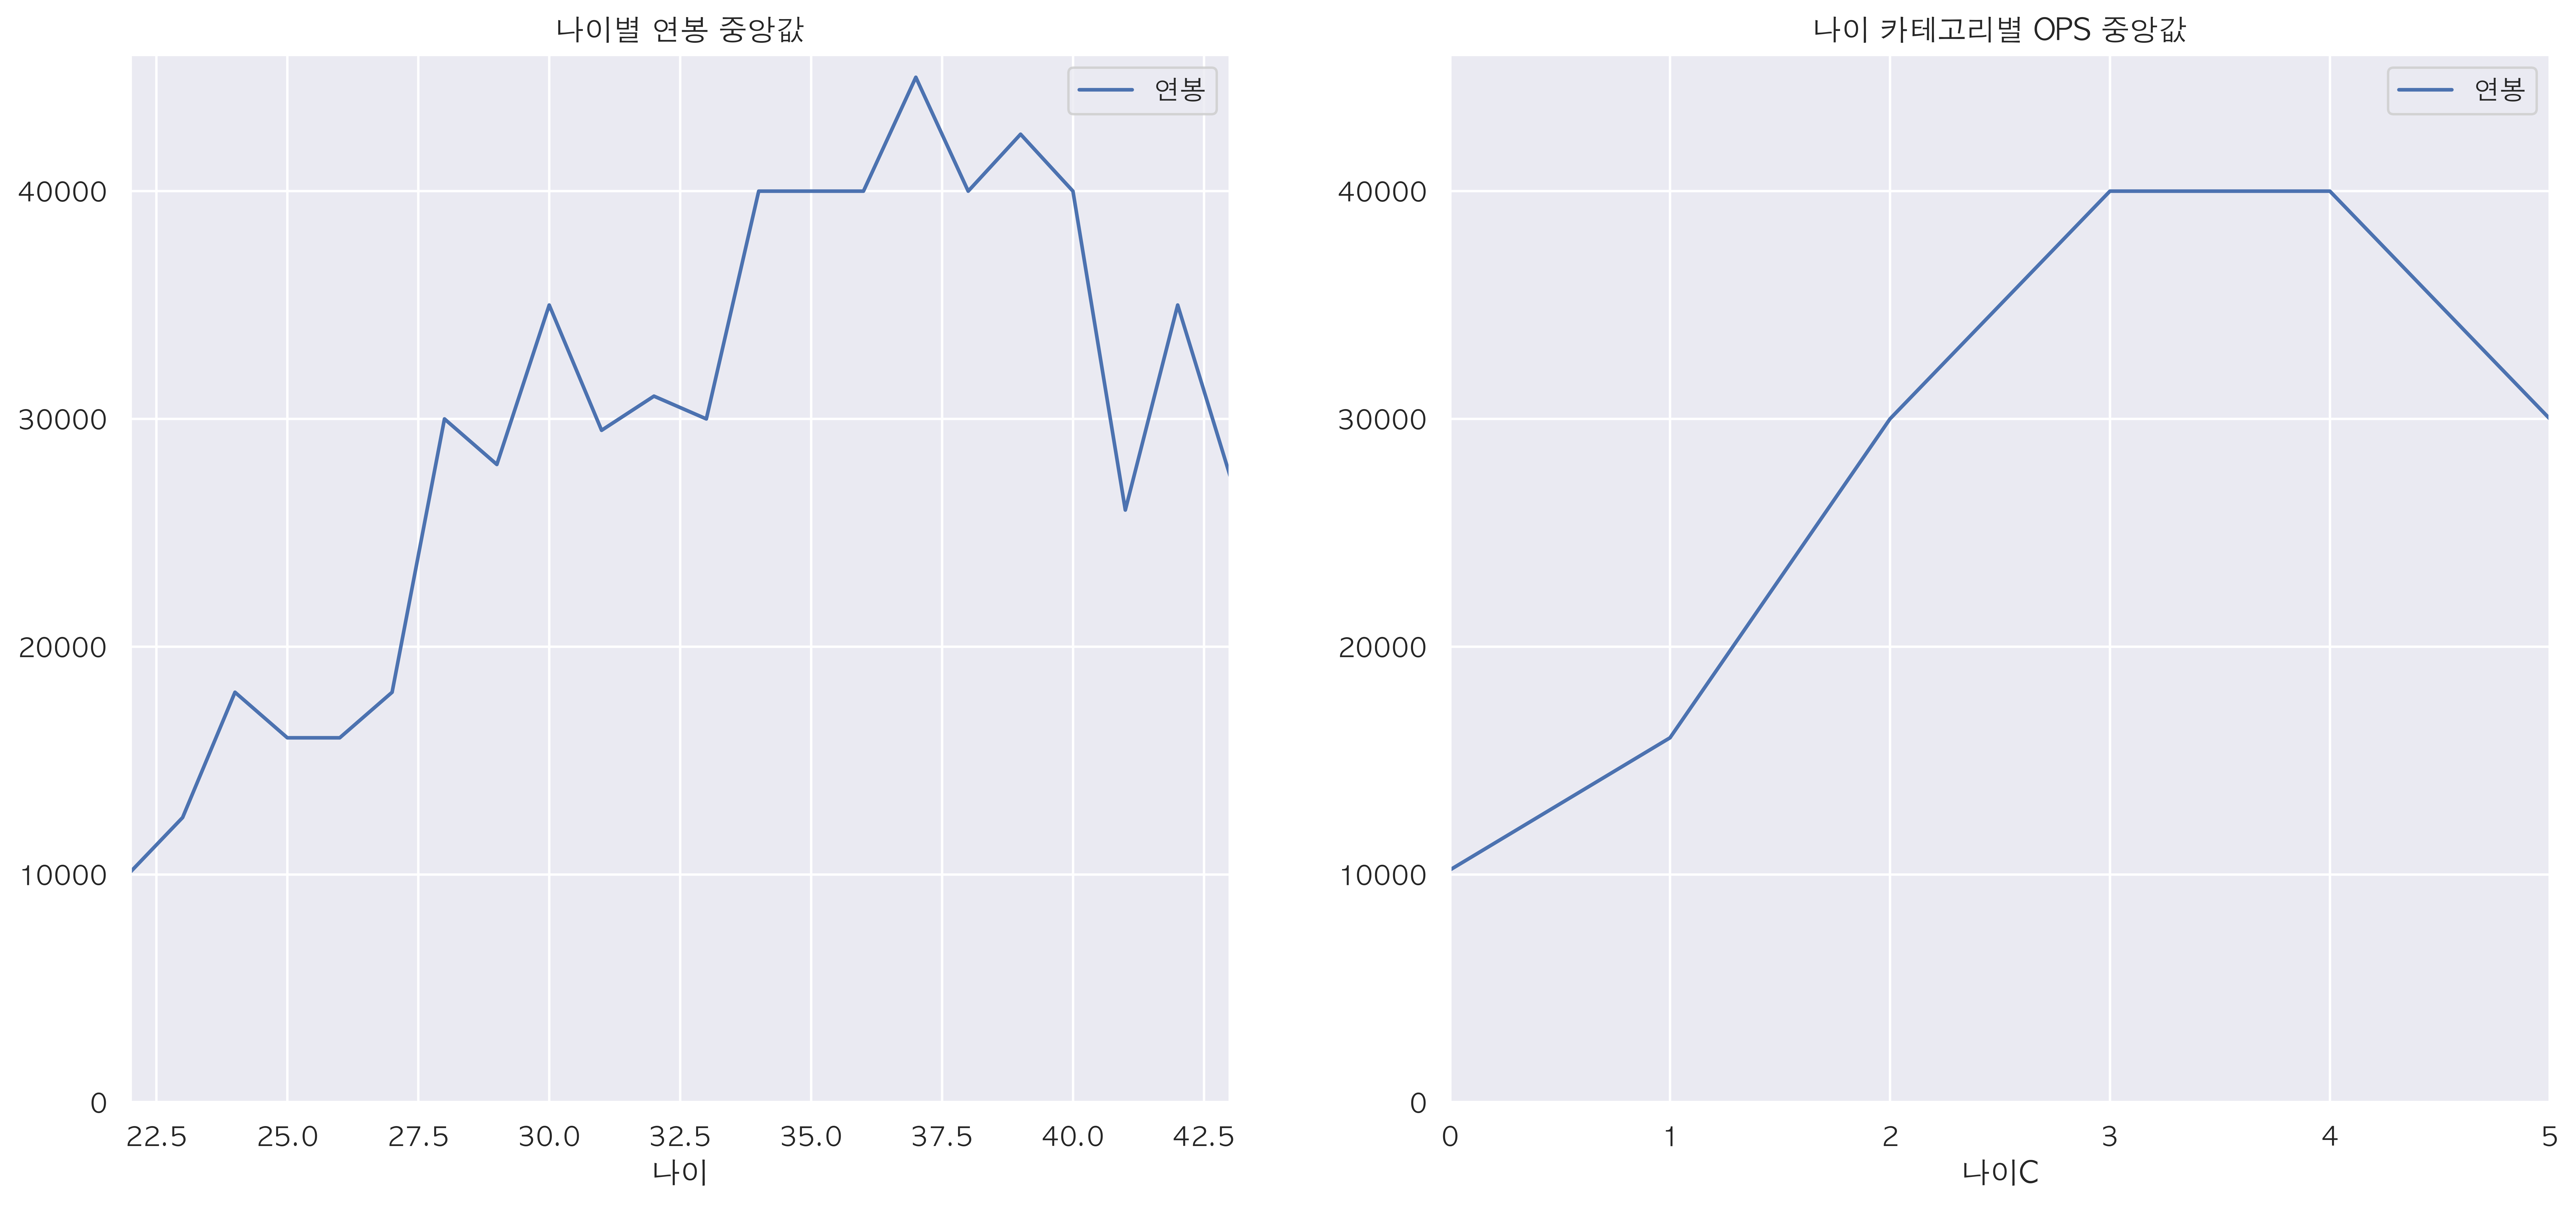

In [38]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df2[['나이', '연봉']].groupby('나이').median().plot(ax=ax[0])
ax[0].set_title('나이별 연봉 중앙값')
ax[0].set_ylim(0, 46000)

df2[['나이C', '연봉']].groupby('나이C').median().plot(ax=ax[1])
ax[1].set_title('나이 카테고리별 OPS 중앙값')
ax[1].set_ylim(0, 46000)

In [39]:
df2['이적'] = df2['이적'].astype(float)

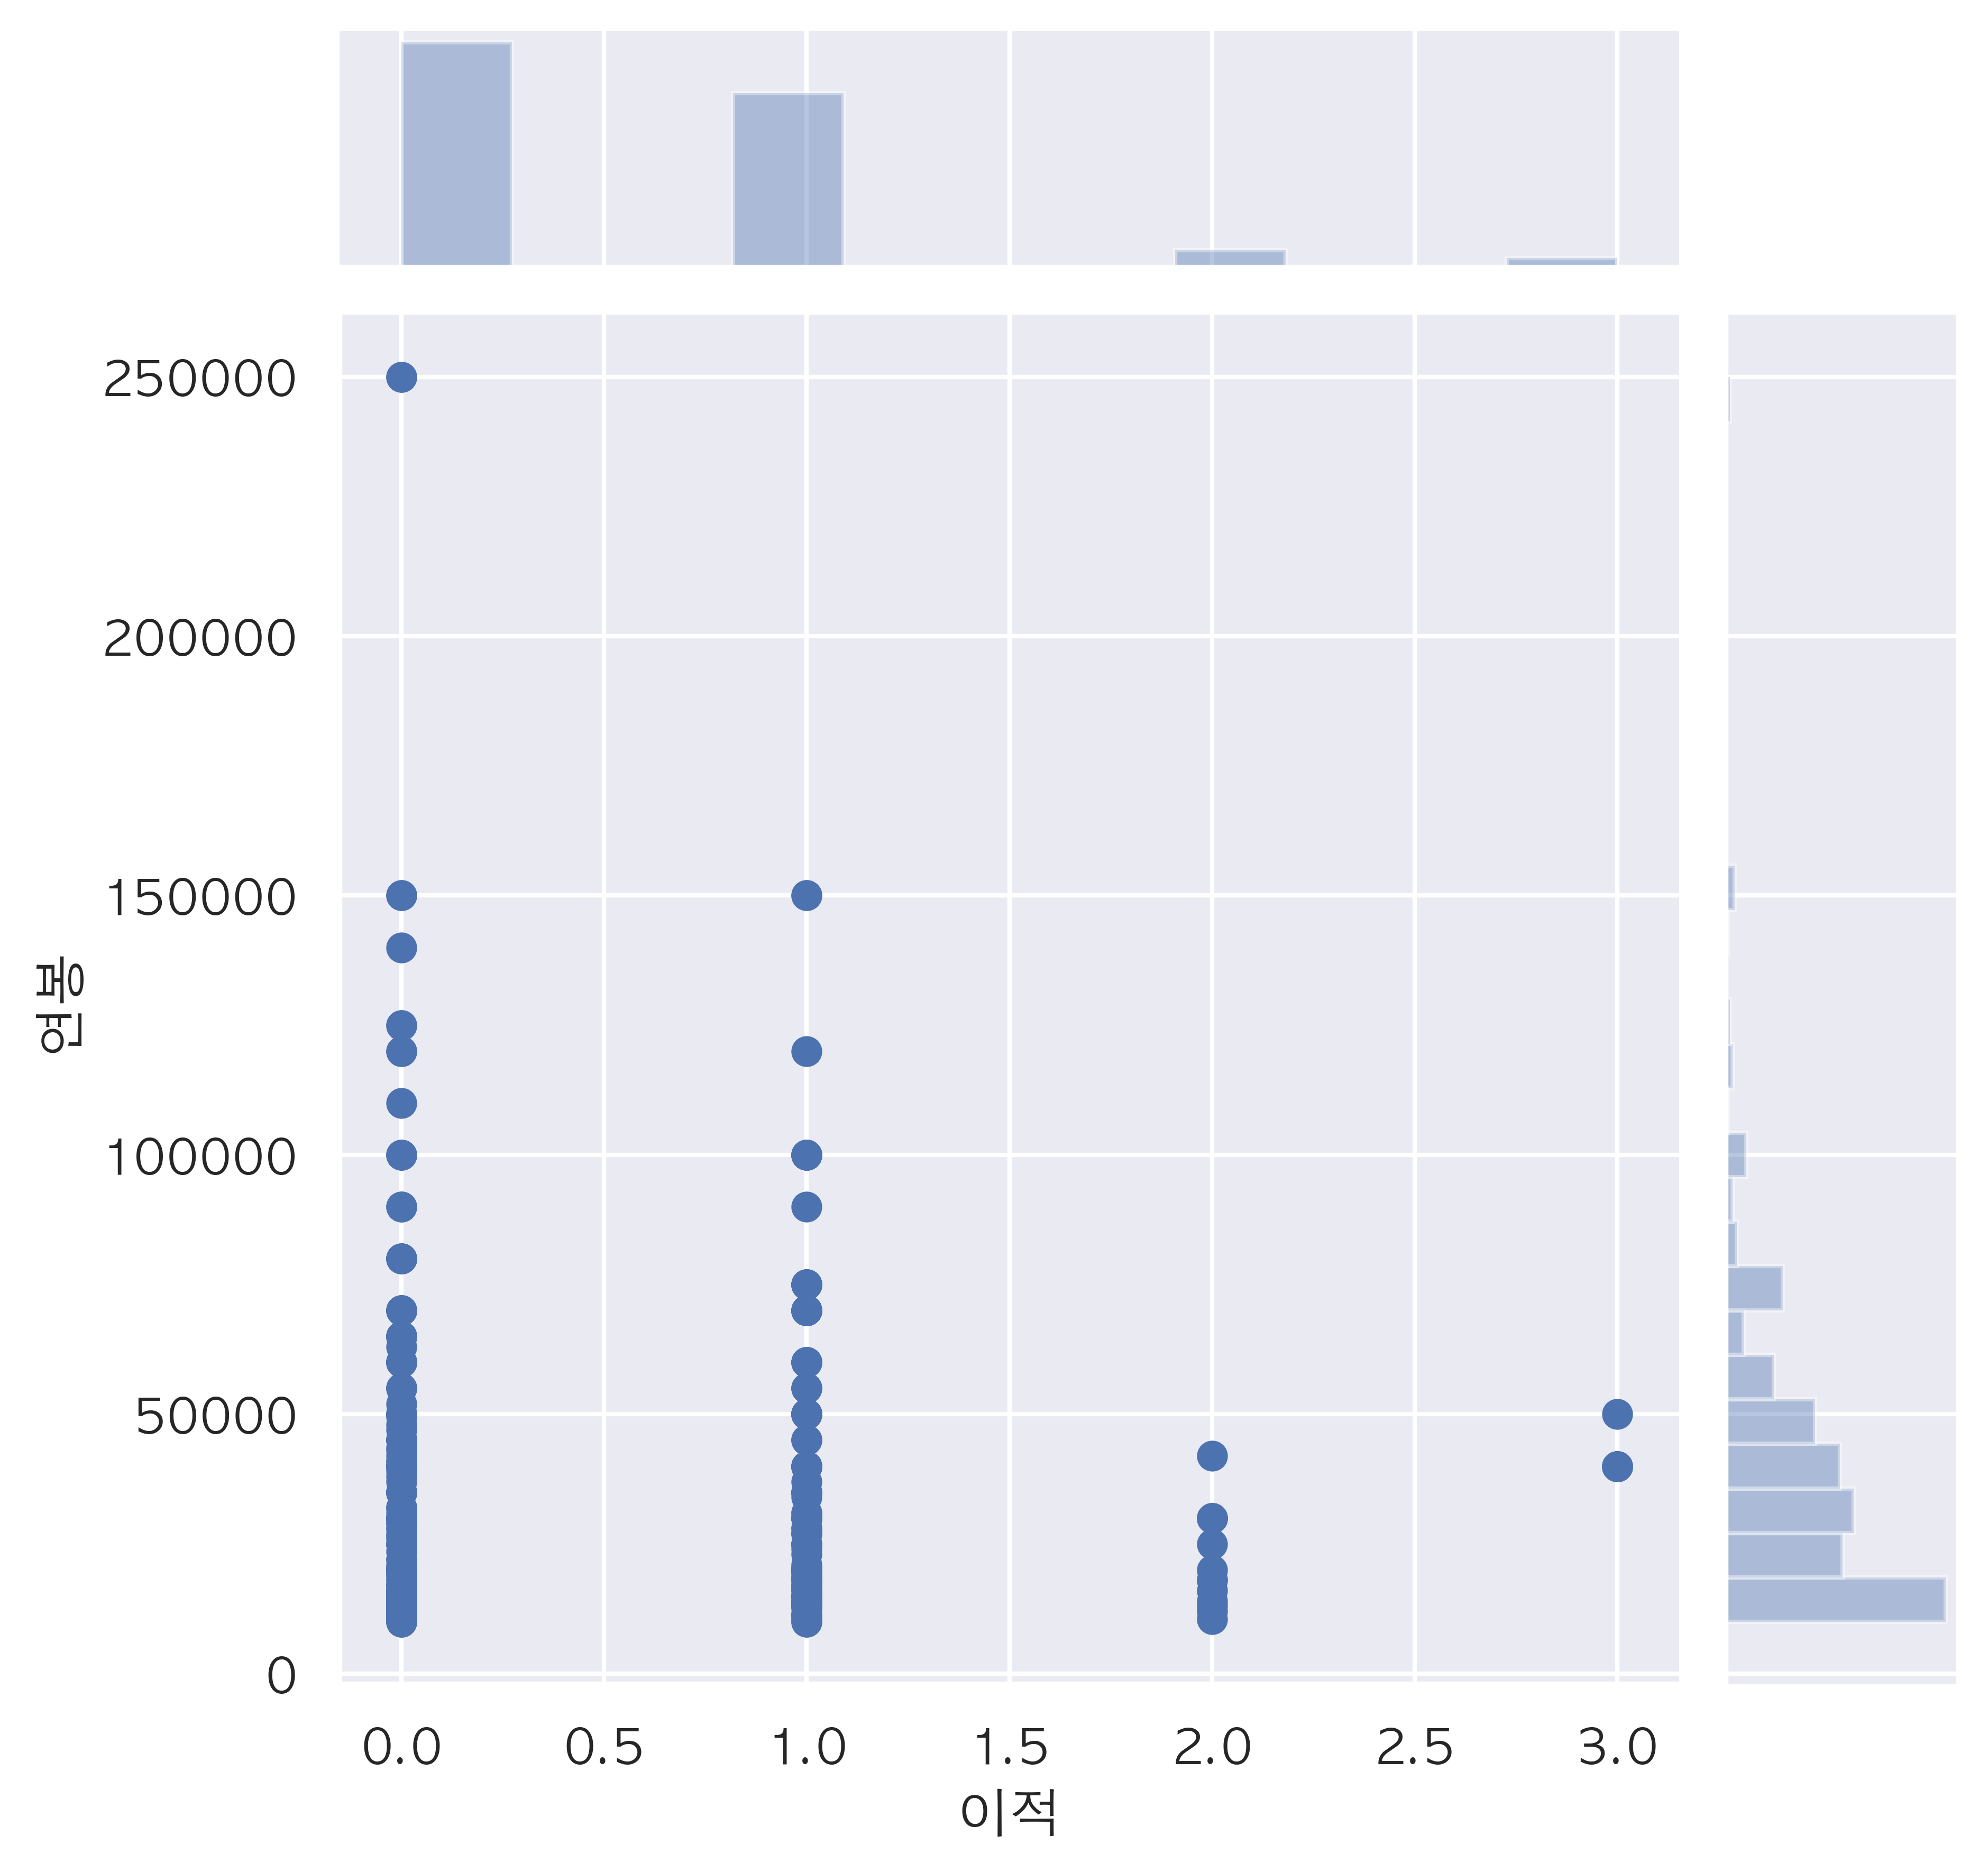

In [43]:
sns.jointplot(x='이적', y='연봉', data=df2)
plt.show()

In [ ]:
df1.columns

In [ ]:
df2['K'] = df2['삼진']/(df2['타석'] - df2['고4'])

In [ ]:
# 변수마다 차이가 커서 scaling을 해줘야 함

df1[['G', '루타', '도루', '고4', '타3', 'BABIP', '이적',
     'ISOD', 'BBK', '경험N', '횟수']].plot.box()
plt.show()

In [ ]:
# 전성기인 27살에 가장 높은 연봉을 받을 것이다 => 30대 연봉이 더 높았고
# 학력은 별 상관 없는 듯.

### 1. 모델1

In [44]:
model = sm.OLS.from_formula(
    '연봉 ~ C(시즌C)+ C(나이C):scale(횟수) + scale(G) + scale(루타) + scale(도루) +scale(고4) + scale(타3) + C(외국인) + scale(BABIP) +scale(이적) + scale(ISOD) + scale(BBK) +scale(경험N)', data=df2)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     연봉   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     26.48
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           1.23e-56
Time:                        18:57:27   Log-Likelihood:                -4255.3
No. Observations:                 376   AIC:                             8551.
Df Residuals:                     356   BIC:                             8629.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              3.391e+

In [46]:
from sklearn.model_selection import KFold
scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df2)):
    df_train = df2.iloc[idx_train]
    df_test = df2.iloc[idx_test]
    model = sm.OLS.from_formula(
        '연봉 ~ C(시즌C)+ C(나이C):scale(횟수) + scale(G) + scale(홈런) + scale(루타) + scale(도루)\
        +scale(고4) + scale(타3) + C(외국인) + scale(BABIP) +C(이적C) + scale(ISOD) + scale(BBK) +scale(경험N)', data=df_train)
    result = model.fit()
    pred = result.predict(df_test)
    rss = ((df_test.연봉 - pred) ** 2).sum()
    tss = ((df_test.연봉 - df_test.연봉.mean()) ** 2).sum()
    rsquared = 1 - rss / tss
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

학습 R2 = 0.65351717, 검증 R2 = 0.41579357
학습 R2 = 0.59698154, 검증 R2 = 0.37477374
학습 R2 = 0.57397897, 검증 R2 = 0.63535737
학습 R2 = 0.57172492, 검증 R2 = 0.63722834
학습 R2 = 0.59910966, 검증 R2 = 0.44570179


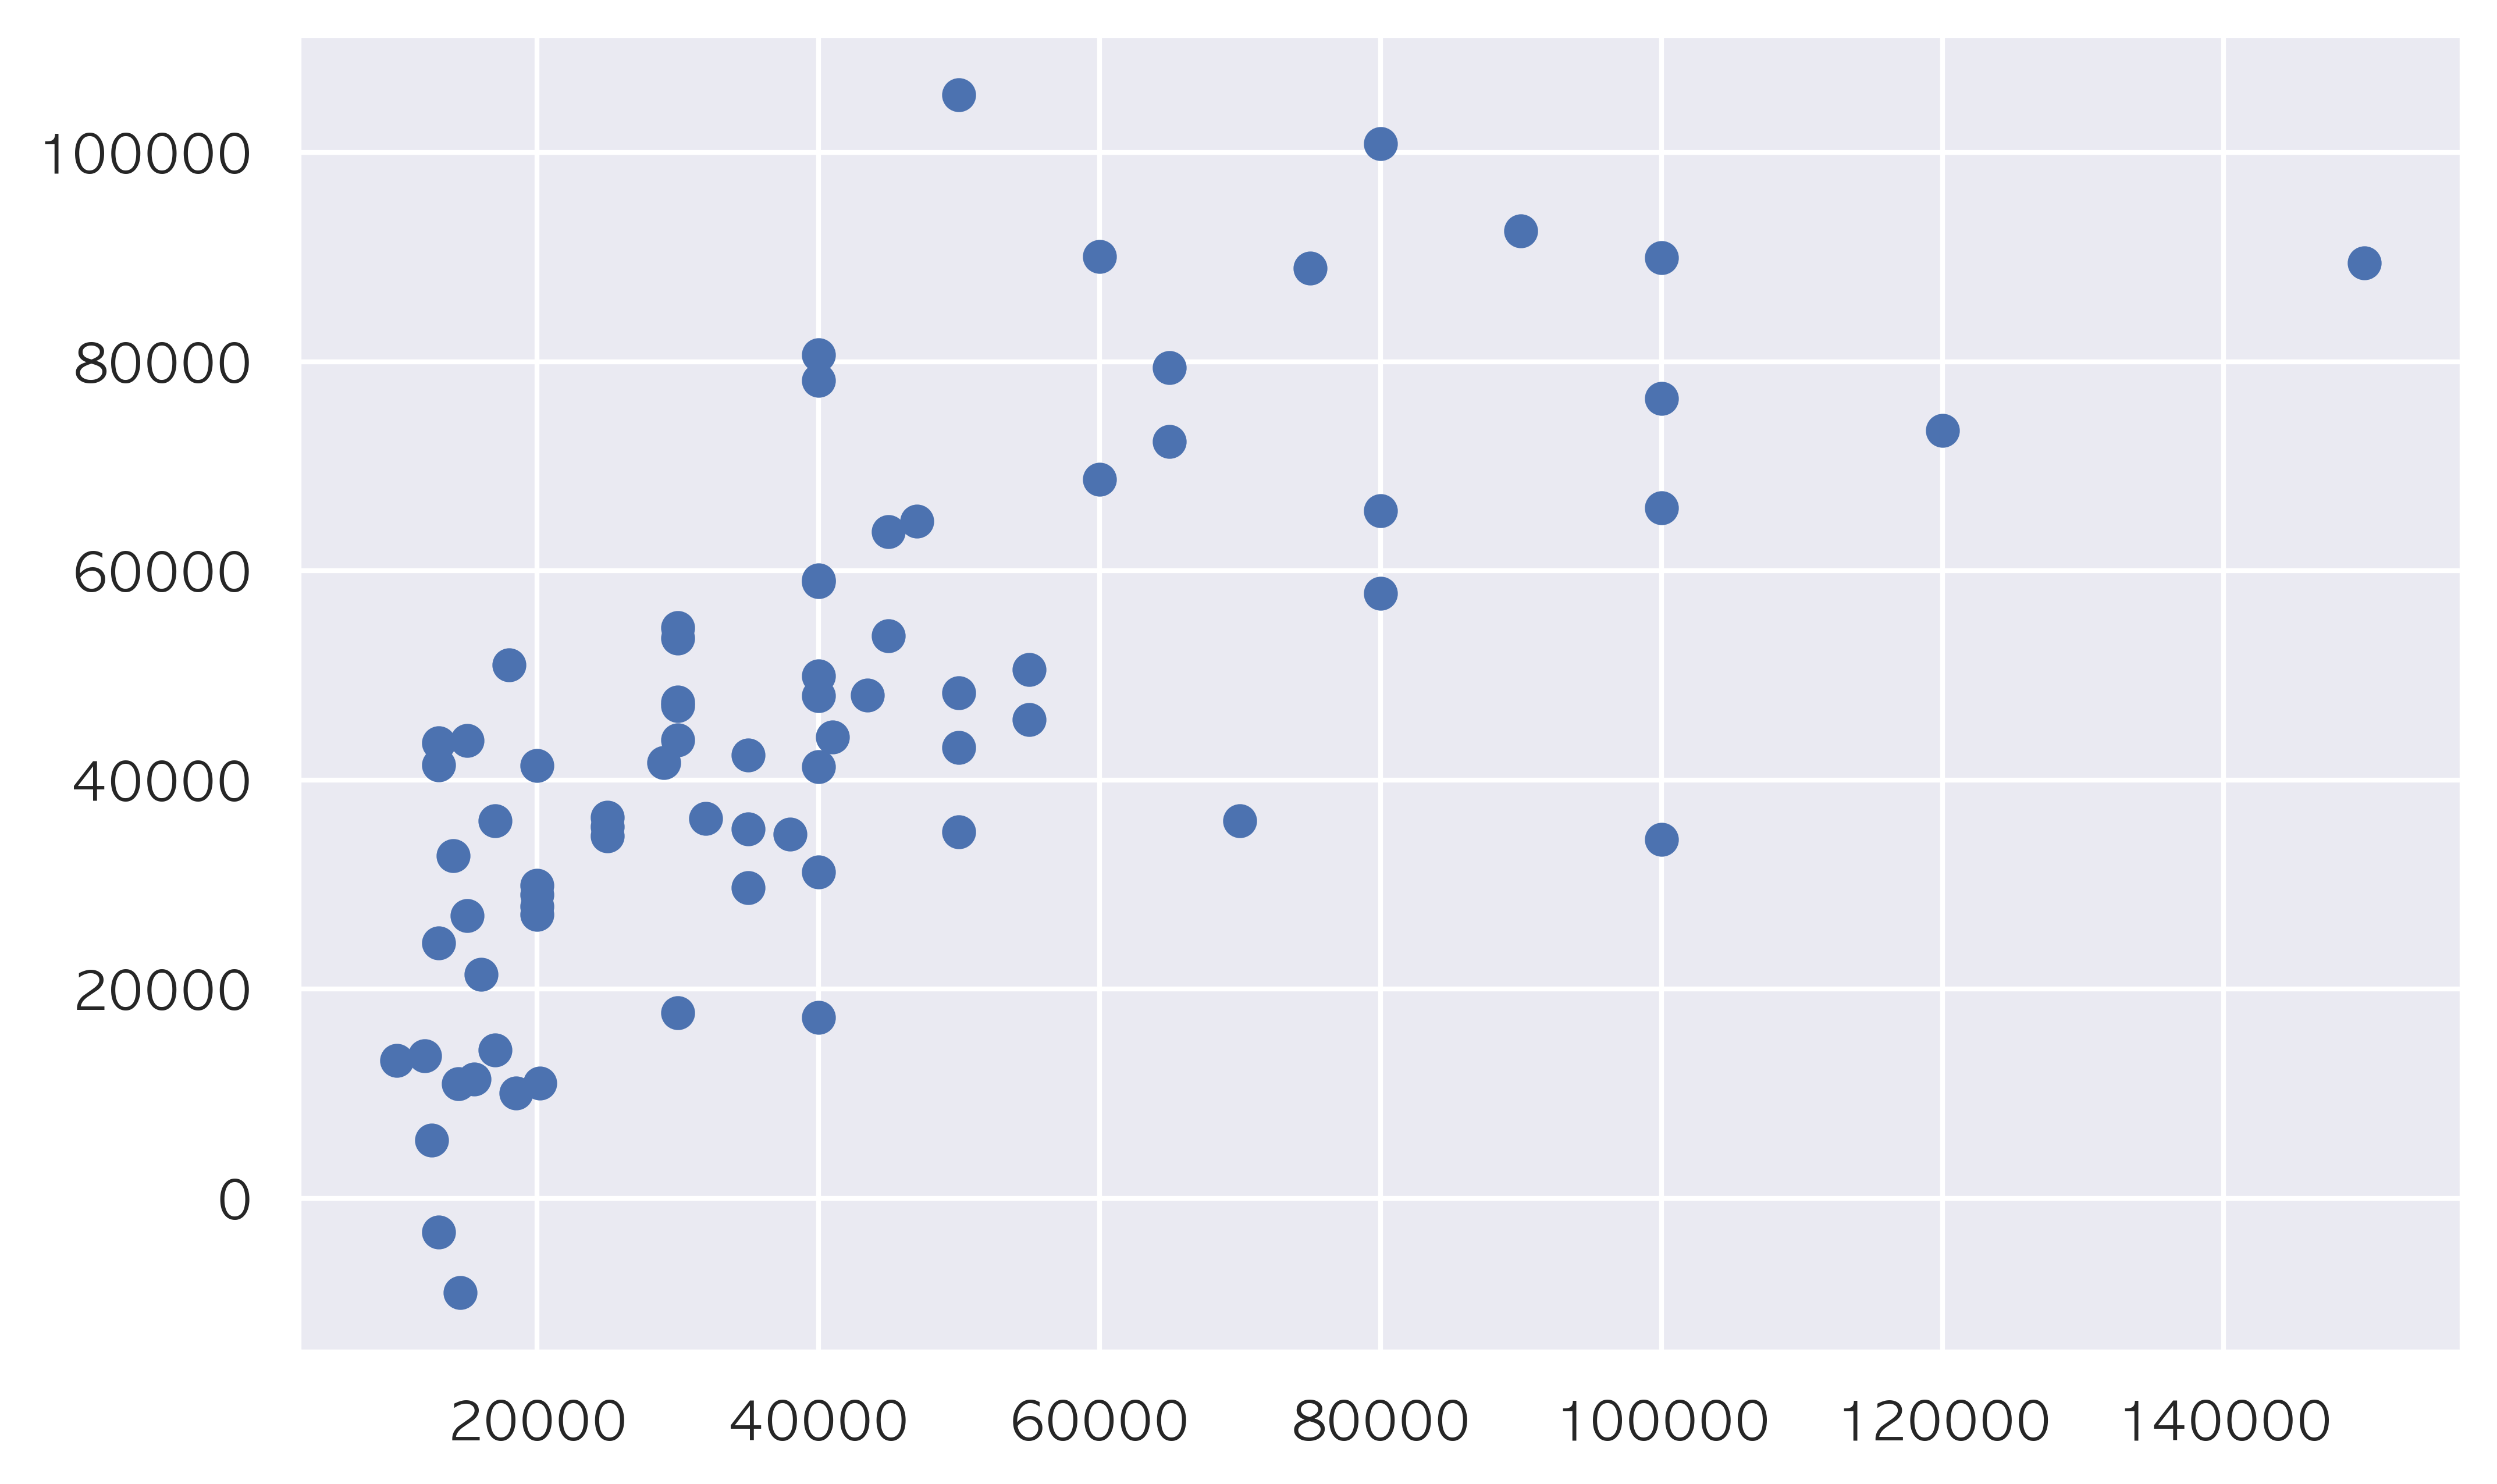

In [47]:
plt.scatter(df_test['연봉'], pred)

### 2. 모델 2

In [48]:
df2['로그연봉'] = 1.5 * np.log(df2['연봉'])

In [52]:
model = sm.OLS.from_formula(
    '로그연봉 ~ +C(포지션) + C(시즌C)+ C(나이C):scale(횟수) + scale(G) + scale(루타) + scale(도루) +scale(고4) + scale(타3) + C(외국인) + scale(BABIP) +scale(이적) + scale(ISOD) + scale(BBK) +scale(경험N)', data=df2)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   로그연봉   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     34.89
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           1.89e-82
Time:                        18:58:09   Log-Likelihood:                -284.77
No. Observations:                 376   AIC:                             625.5
Df Residuals:                     348   BIC:                             735.6
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                15.11

In [53]:
from sklearn.model_selection import KFold
scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=3)
for i, (idx_train, idx_test) in enumerate(cv.split(df2)):
    df_train = df2.iloc[idx_train]
    df_test = df2.iloc[idx_test]
    model = sm.OLS.from_formula(
        '로그연봉 ~ +C(포지션) + C(시즌C)+ C(나이C):scale(횟수) + scale(G) + scale(루타) + scale(도루) +scale(고4) + scale(타3) + C(외국인) + scale(BABIP) +scale(이적) + scale(ISOD) + scale(BBK) +scale(경험N)', data=df_train)
    result = model.fit()
    pred = result.predict(df_test)
    rss = ((df_test.로그연봉 - pred) ** 2).sum()
    tss = ((df_test.로그연봉 - df_test.로그연봉.mean()) ** 2).sum()
    rsquared = 1 - rss / tss
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

학습 R2 = 0.75124984, 검증 R2 = 0.60064984
학습 R2 = 0.73338255, 검증 R2 = 0.69333434
학습 R2 = 0.72414732, 검증 R2 = 0.72779370
학습 R2 = 0.73851699, 검증 R2 = 0.65458577
학습 R2 = 0.72648458, 검증 R2 = 0.71287227


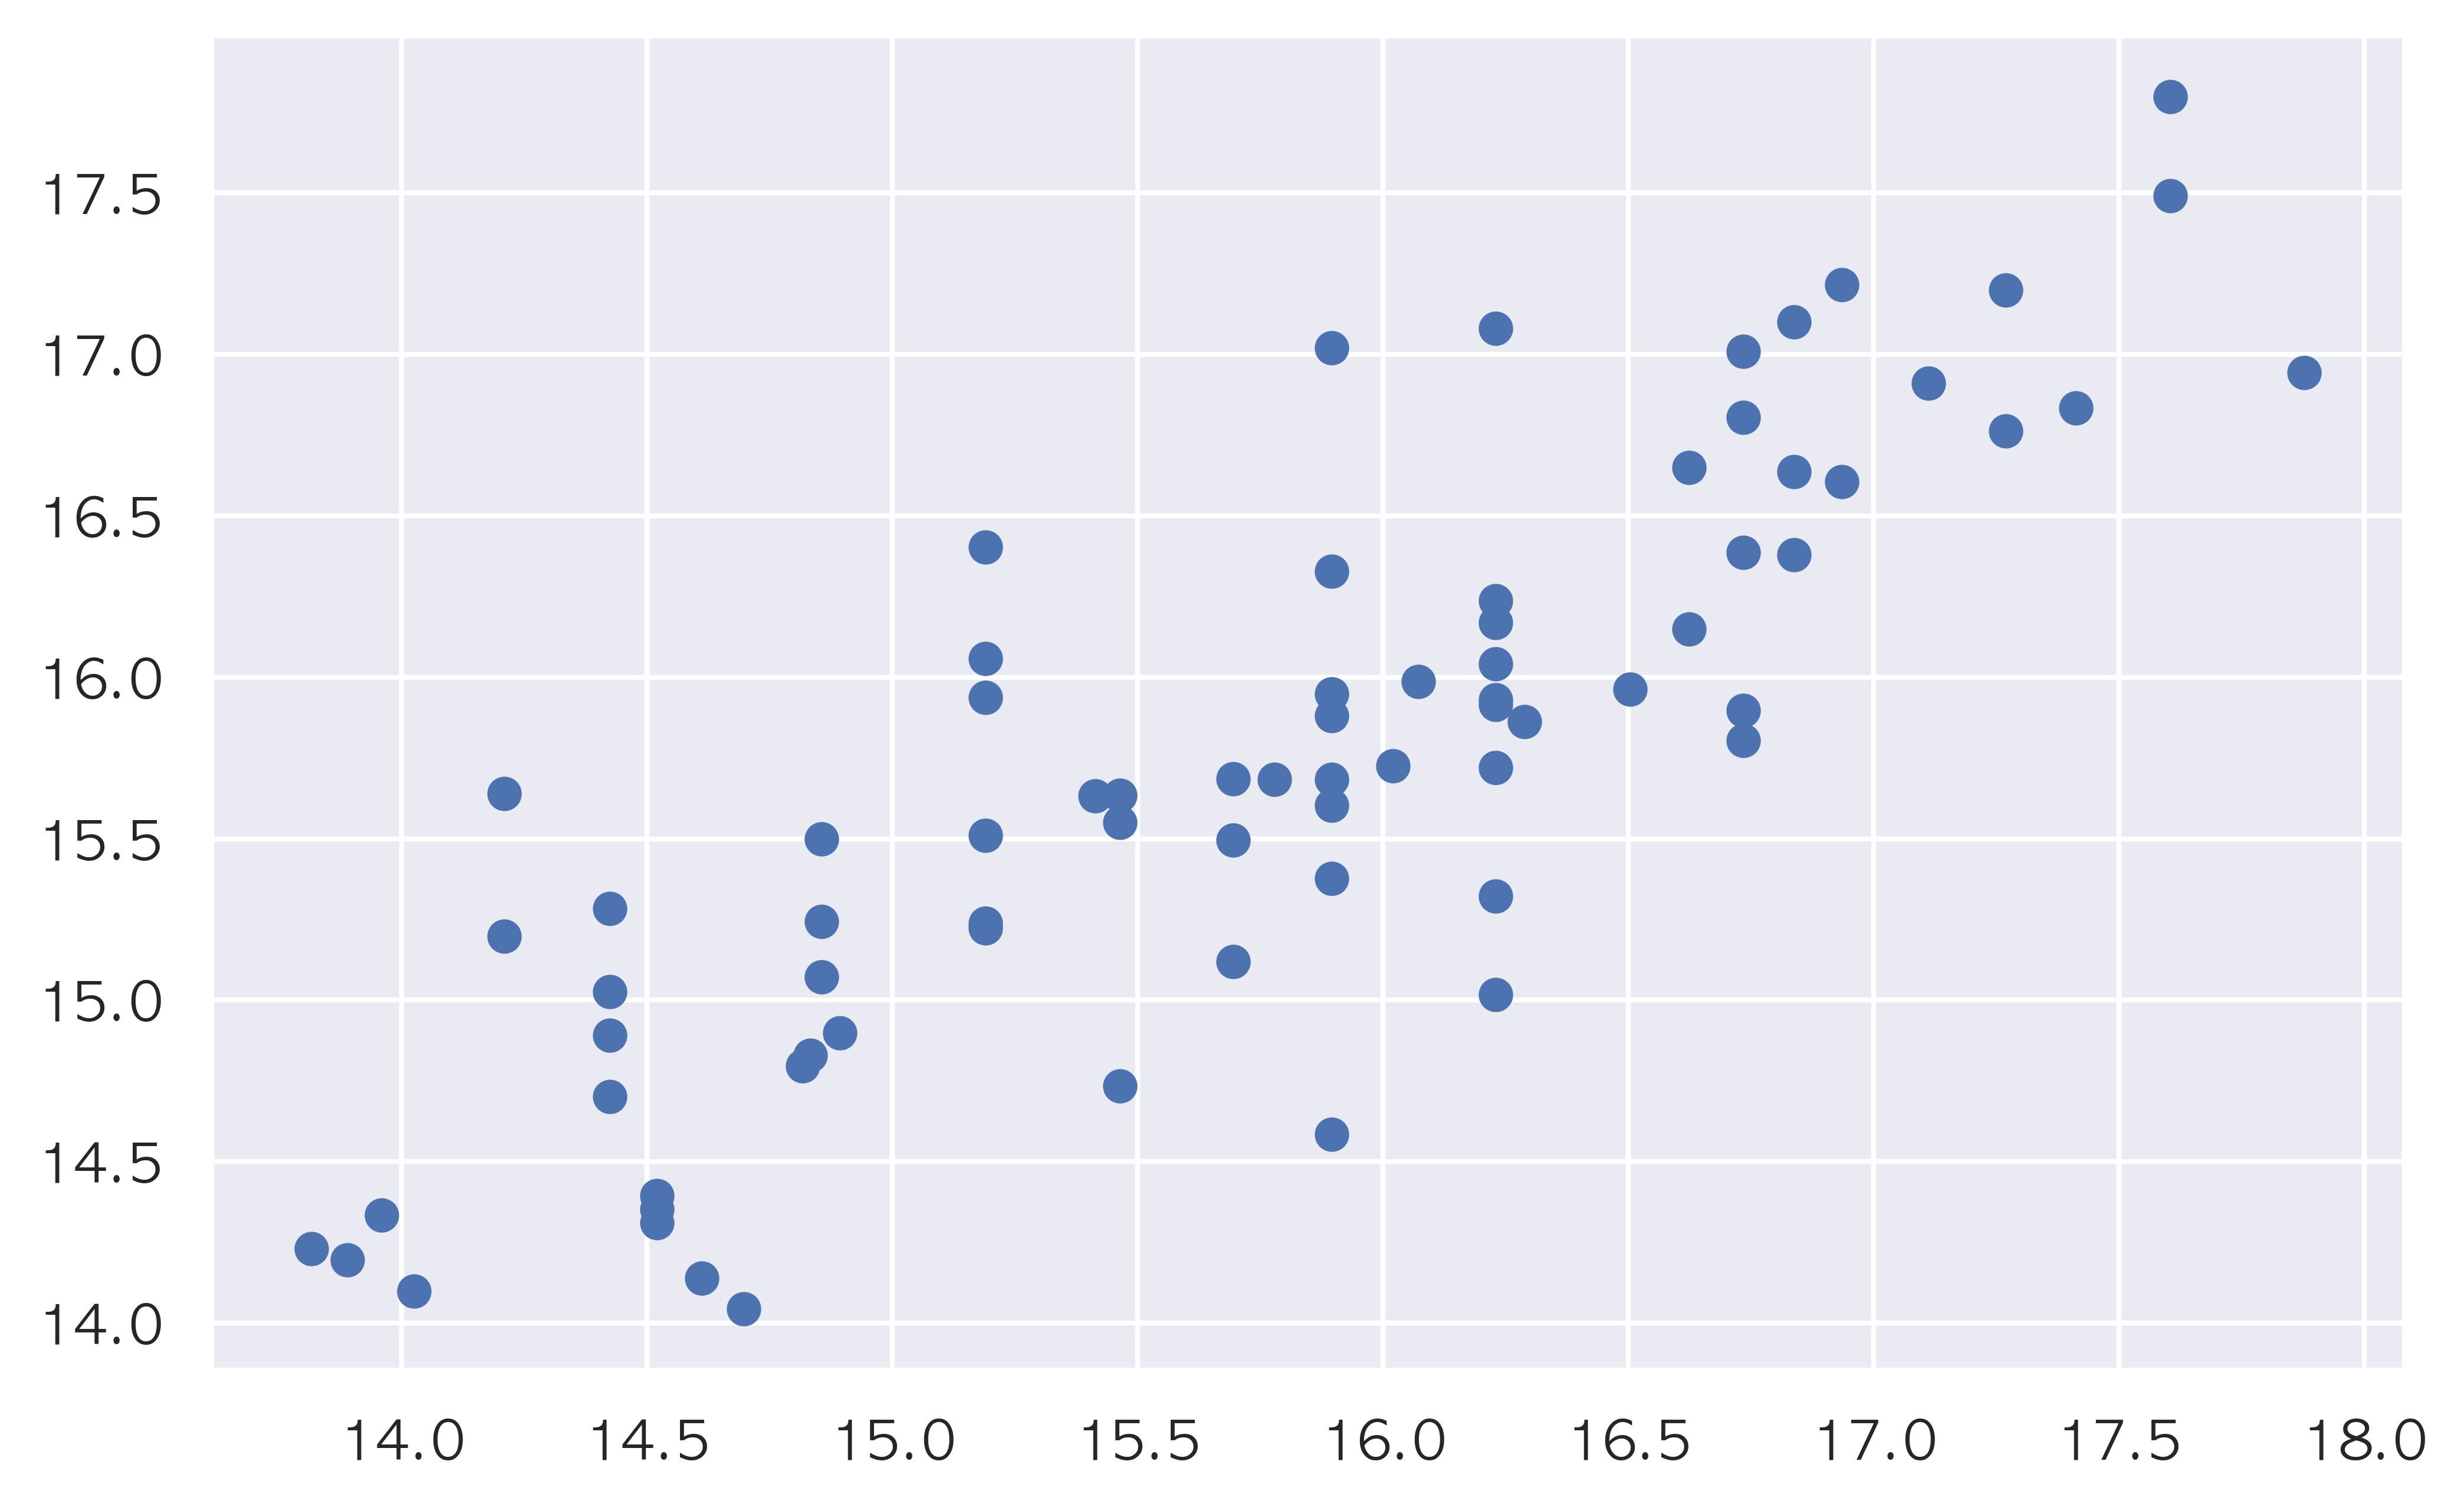

In [54]:
plt.scatter(df_test['로그연봉'], pred)

### 3. 모델3

In [55]:
df2['수상'][df2.수상.isna()] = '0'

In [56]:
df2.수상

0       0
1      GG
2      GG
3      GG
4      GG
       ..
371     0
372     0
373     0
374     0
375     0
Name: 수상, Length: 376, dtype: object

In [57]:
df2['MVP'] = df2.MVP.astype(int)

In [58]:
df2['수상N'] = None
for x in df2['수상']:
    if x != '0':
        df2['수상N'][df2['수상'] == x] = 1
    else:
        df2['수상N'][df2['수상'] == x] = 0

In [59]:
df2['수상N'] = df2['수상N'].astype(int)

In [60]:
df2['수상N1'] = None


for name in df2['이름'].unique():
    a = 0
    N = []
    for x in df2[df2['이름'] == name]["수상N"]:
        a += x
        N.append(a)
    id_x = df2['수상N1'][df2['이름'] == name].index
    df2['수상N1'].loc[id_x] = N

In [61]:
df2['MVP1'] = None


for name in df2['이름'].unique():
    a = 0
    N = []
    for x in df2[df2['이름'] == name]["MVP"]:
        a += x
        N.append(a)
    id_x = df2['MVP1'][df2['이름'] == name].index
    df2['MVP1'].loc[id_x] = N

In [63]:
df2.head()

ID   이름    시즌   팀 포지션    나이      G     타석     타수     득점     안타     타1  \
0  0.0  테임즈  2014  NC  1B  29.0  125.0  514.0  443.0   95.0  152.0   79.0   
1  0.0  테임즈  2015  NC  1B  30.0  142.0  595.0  472.0  130.0  180.0   86.0   
2  0.0  테임즈  2016  NC  1B  31.0  123.0  529.0  436.0  118.0  140.0   67.0   
3  1.0  이대호  2010  롯데  3B  29.0  127.0  552.0  478.0   99.0  174.0  117.0   
4  1.0  이대호  2011  롯데  1B  30.0  133.0  570.0  493.0   76.0  176.0  122.0   

     타2   타3    홈런     루타     타점    도루   도실     볼넷    사구    고4     삼진    병살  \
0  30.0  6.0  37.0  305.0  121.0  11.0  2.0   58.0   7.0   5.0   99.0   6.0   
1  42.0  5.0  47.0  373.0  140.0  40.0  8.0  103.0  13.0  11.0   91.0   7.0   
2  30.0  3.0  40.0  296.0  121.0  13.0  4.0   74.0  12.0   6.0  103.0   2.0   
3  13.0  0.0  44.0  319.0  133.0   0.0  2.0   61.0  10.0   6.0   77.0  15.0   
4  26.0  1.0  27.0  285.0  113.0   2.0  0.0   63.0   8.0   8.0   60.0  22.0   

    희타   희비     타율  ...    wRC  twoBLUCK  threeBLUCK    ISO       BBK   ISOD  \
0  0.0  6.0  0.343  ...  168.3  0.097720    0.019544  0.345  0.079767  0.079   
1  0.0  7.0  0.381  ...  222.3  0.125749    0.014970  0.409 -0.020168  0.117   
2  0.0  7.0  0.321  ...  170.5  0.102389    0.010239  0.358  0.054820  0.106   
3  0.0  3.0  0.364  ...  192.4  0.036415    0.000000  0.303  0.028986  0.080   
4  0.0  6.0  0.357  ...  180.0  0.064039    0.002463  0.221 -0.005263  0.076   

         연봉   횟수   경험      데뷔      학력                               계약_x  수상  \
0   25000.0  1.0  0.0  2014.0  용병-용병대                             ['연도']   0   
1  125000.0  2.0  1.0  2014.0  용병-용병대                             ['연도']  GG   
2  125000.0  3.0  2.0  2014.0  용병-용병대                             ['연도']  GG   
3   39000.0  1.0  0.0  2001.0     경남고  ['연도', '2001년', '2012년', '2017년']  GG   
4   63000.0  2.0  1.0  2001.0     경남고  ['연도', '2001년', '2012년', '2017년']  GG   

   MVP 계약_y 참고 시즌C   경험N 외국인     BABIP   이적  이적C  나이C       로그연봉  수상N  수상N1  \
0    0  NaN  0   1   0.0   1  0.382060  0.0    0  2.0  15.189947    0     0   
1    1  NaN  0   2   1.0   1  0.406728  0.0    0  2.0  17.604104    1     1   
2    0  NaN  0   2   2.0   1  0.349650  0.0    0  2.0  17.604104    1     2   
3    1  NaN  0   0   9.0   0  0.367232  0.0    0  2.0  15.856975    1     1   
4    0  NaN  0   0  10.0   0  0.372500  0.0    0  2.0  16.576335    1     2   

   MVP1  
0     0  
1     1  
2     1  
3     1  
4     1  

[5 rows x 58 columns]

In [64]:
df2.columns

Index(['ID', '이름', '시즌', '팀', '포지션', '나이', 'G', '타석', '타수', '득점', '안타', '타1',
       '타2', '타3', '홈런', '루타', '타점', '도루', '도실', '볼넷', '사구', '고4', '삼진', '병살',
       '희타', '희비', '타율', '출루', '장타', 'OPS', 'wOBA', 'wRC', 'twoBLUCK',
       'threeBLUCK', 'ISO', 'BBK', 'ISOD', '연봉', '횟수', '경험', '데뷔', '학력',
       '계약_x', '수상', 'MVP', '계약_y', '참고', '시즌C', '경험N', '외국인', 'BABIP', '이적',
       '이적C', '나이C', '로그연봉', '수상N', '수상N1', 'MVP1'],
      dtype='object')

In [65]:
model = sm.OLS.from_formula(
    '로그연봉 ~ +C(포지션) + C(시즌C)+ C(나이C):scale(횟수) + scale(G) + scale(루타) + scale(도루) +scale(고4) + scale(타3) + C(외국인) + scale(BABIP) +scale(이적) + scale(ISOD) +scale(경험N) +scale(수상N1) +scale(MVP1)', data=df2)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   로그연봉   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     35.49
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           1.02e-84
Time:                        18:58:47   Log-Likelihood:                -276.96
No. Observations:                 376   AIC:                             611.9
Df Residuals:                     347   BIC:                             725.9
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                15.07

In [66]:
from sklearn.model_selection import KFold
scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=2)
for i, (idx_train, idx_test) in enumerate(cv.split(df2)):
    df_train = df2.iloc[idx_train]
    df_test = df2.iloc[idx_test]
    model = sm.OLS.from_formula(
        '로그연봉 ~ +C(포지션) + C(시즌C)+ C(나이C):scale(횟수) + scale(G) + scale(루타) + scale(도루) +scale(고4) + scale(타3) + C(외국인) + scale(BABIP) +scale(이적) + scale(ISOD) +scale(경험N) +scale(수상N1)', data=df_train)
    result = model.fit()
    pred = result.predict(df_test)
    rss = ((df_test.로그연봉 - pred) ** 2).sum()
    tss = ((df_test.로그연봉 - df_test.로그연봉.mean()) ** 2).sum()
    rsquared = 1 - rss / tss
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

학습 R2 = 0.73169574, 검증 R2 = 0.71480370
학습 R2 = 0.72730254, 검증 R2 = 0.72529243
학습 R2 = 0.76023092, 검증 R2 = 0.62170909
학습 R2 = 0.74430678, 검증 R2 = 0.64977303
학습 R2 = 0.73792946, 검증 R2 = 0.67820808


(13.5, 18)

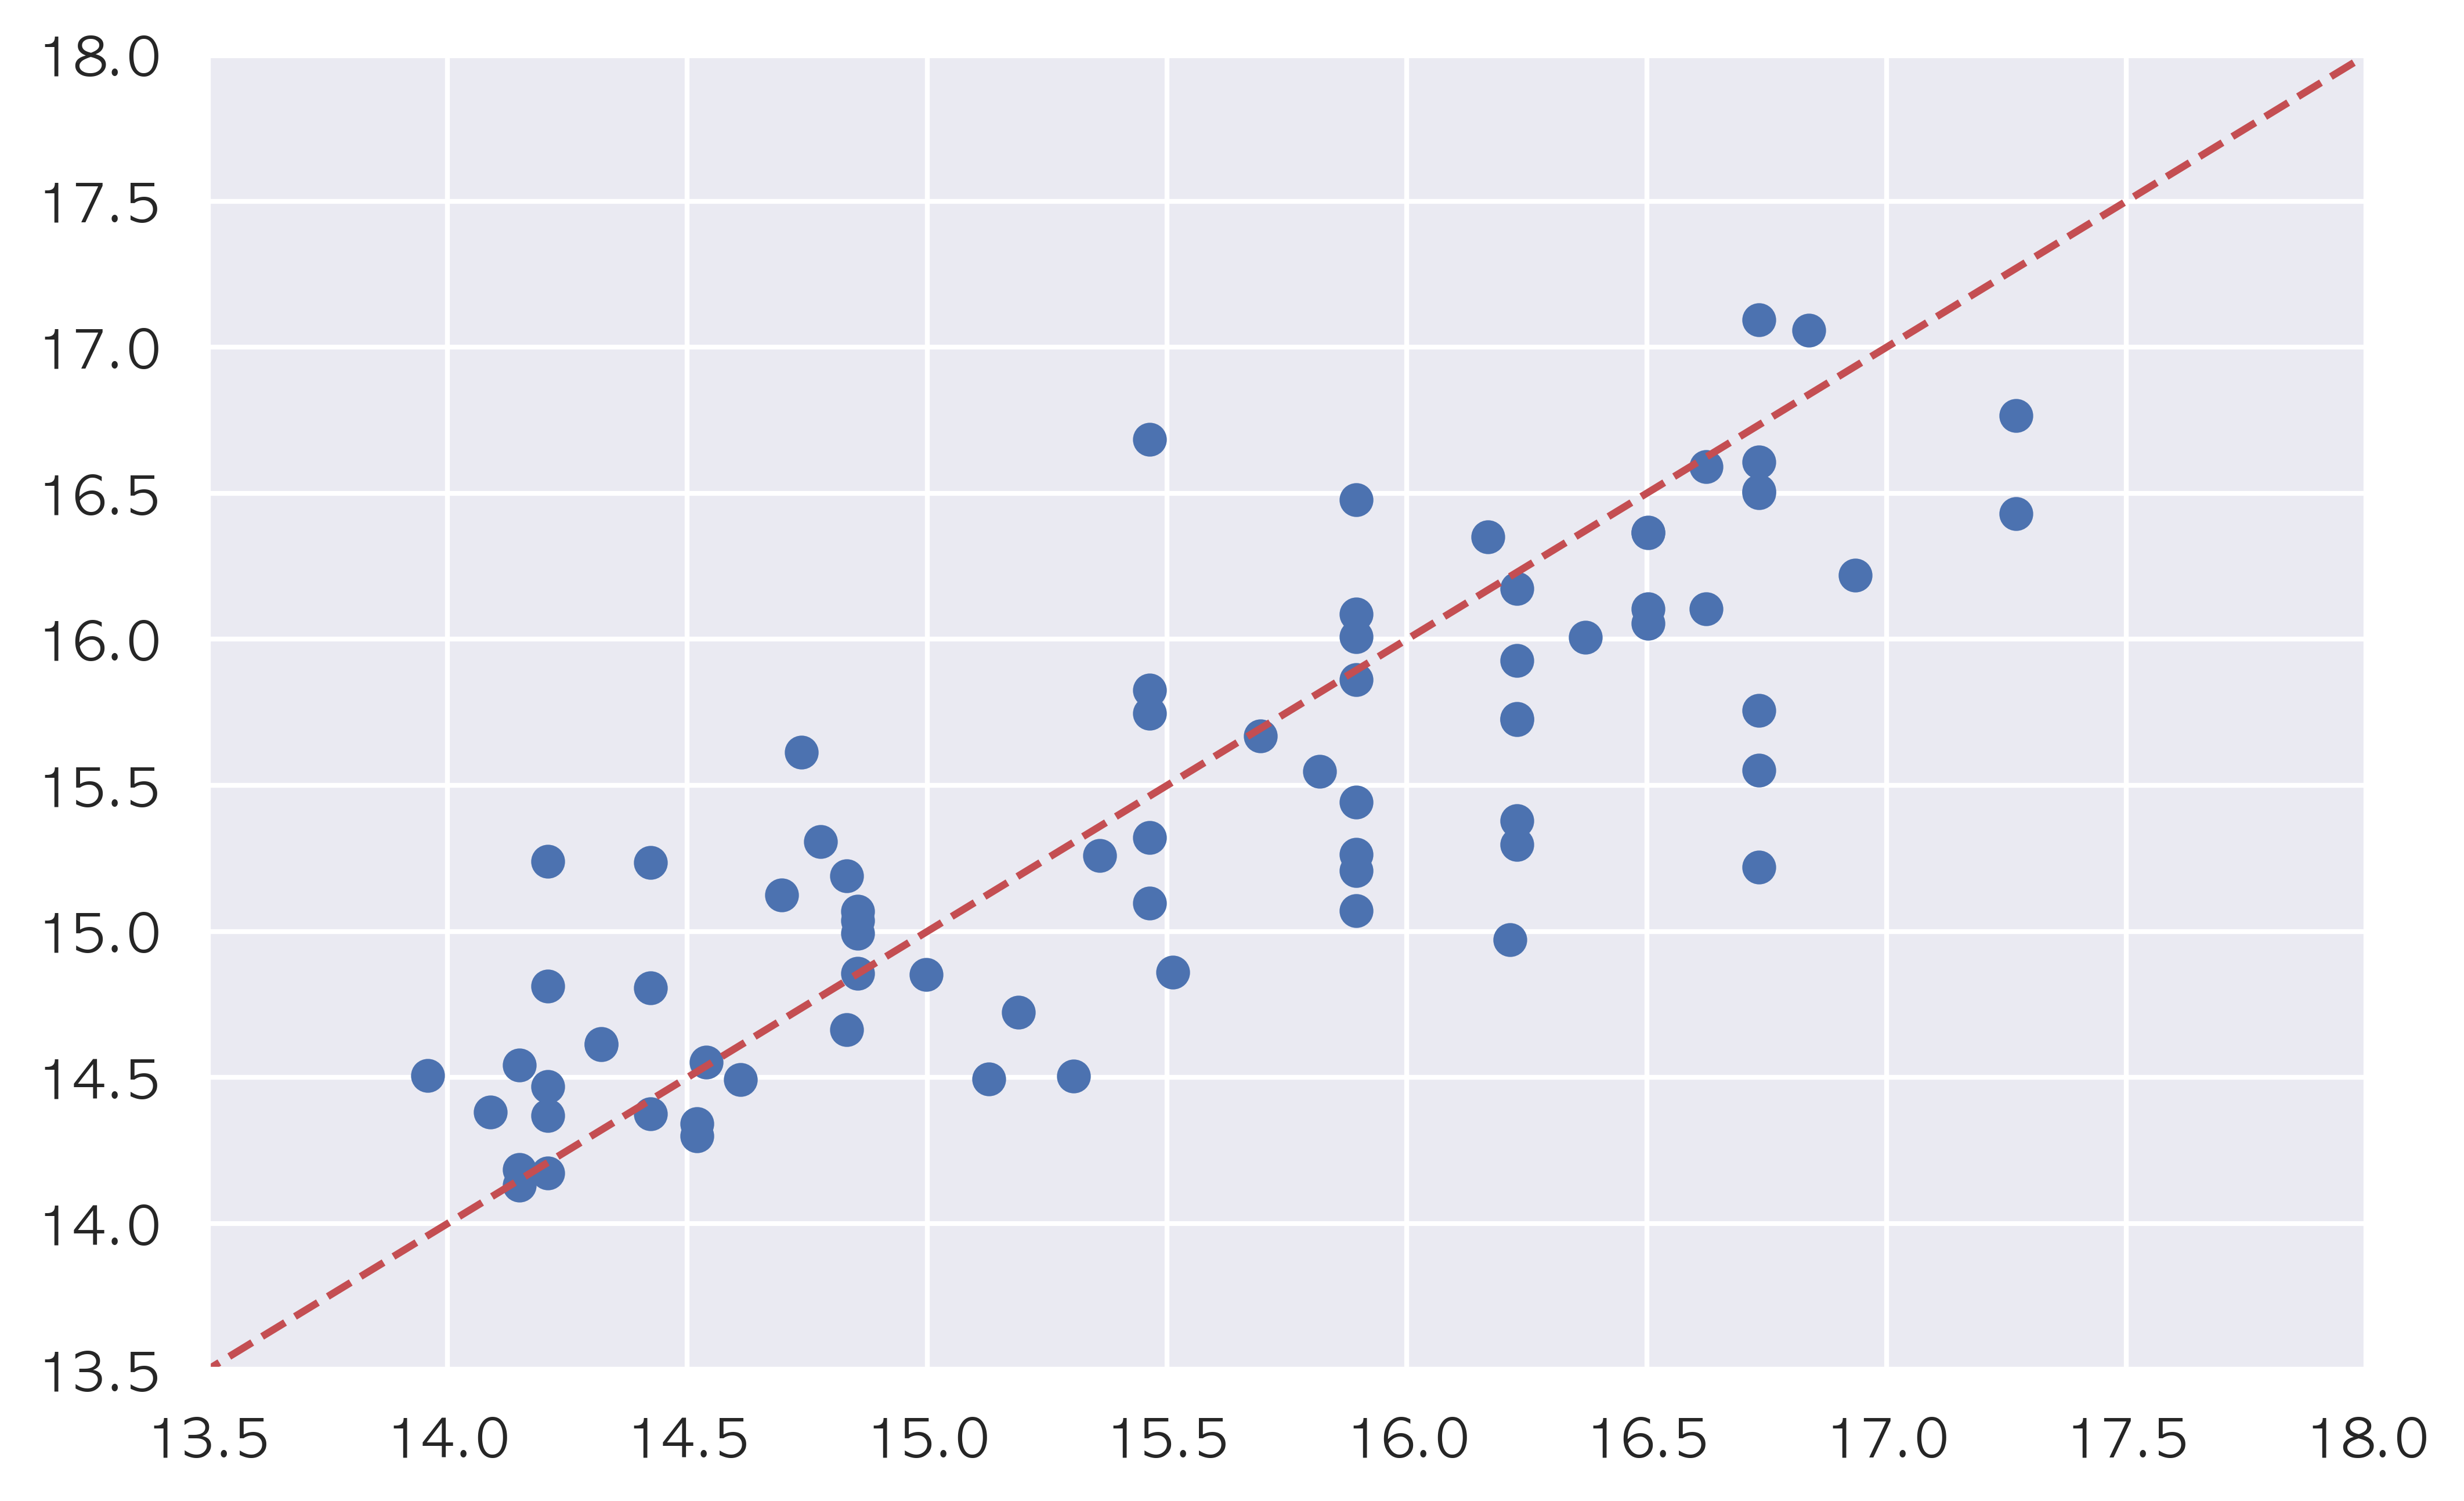

In [67]:
plt.scatter(df_test['로그연봉'], pred)
plt.plot([13, 19], [13, 19], ls='--', c='r')
plt.xlim(13.5, 18)
plt.ylim(13.5, 18)

### 모델 4
 - MVP 추가
 - FA 추가

In [68]:
df2.head()

ID   이름    시즌   팀 포지션    나이      G     타석     타수     득점     안타     타1  \
0  0.0  테임즈  2014  NC  1B  29.0  125.0  514.0  443.0   95.0  152.0   79.0   
1  0.0  테임즈  2015  NC  1B  30.0  142.0  595.0  472.0  130.0  180.0   86.0   
2  0.0  테임즈  2016  NC  1B  31.0  123.0  529.0  436.0  118.0  140.0   67.0   
3  1.0  이대호  2010  롯데  3B  29.0  127.0  552.0  478.0   99.0  174.0  117.0   
4  1.0  이대호  2011  롯데  1B  30.0  133.0  570.0  493.0   76.0  176.0  122.0   

     타2   타3    홈런     루타     타점    도루   도실     볼넷    사구    고4     삼진    병살  \
0  30.0  6.0  37.0  305.0  121.0  11.0  2.0   58.0   7.0   5.0   99.0   6.0   
1  42.0  5.0  47.0  373.0  140.0  40.0  8.0  103.0  13.0  11.0   91.0   7.0   
2  30.0  3.0  40.0  296.0  121.0  13.0  4.0   74.0  12.0   6.0  103.0   2.0   
3  13.0  0.0  44.0  319.0  133.0   0.0  2.0   61.0  10.0   6.0   77.0  15.0   
4  26.0  1.0  27.0  285.0  113.0   2.0  0.0   63.0   8.0   8.0   60.0  22.0   

    희타   희비     타율  ...    wRC  twoBLUCK  threeBLUCK    ISO       BBK   ISOD  \
0  0.0  6.0  0.343  ...  168.3  0.097720    0.019544  0.345  0.079767  0.079   
1  0.0  7.0  0.381  ...  222.3  0.125749    0.014970  0.409 -0.020168  0.117   
2  0.0  7.0  0.321  ...  170.5  0.102389    0.010239  0.358  0.054820  0.106   
3  0.0  3.0  0.364  ...  192.4  0.036415    0.000000  0.303  0.028986  0.080   
4  0.0  6.0  0.357  ...  180.0  0.064039    0.002463  0.221 -0.005263  0.076   

         연봉   횟수   경험      데뷔      학력                               계약_x  수상  \
0   25000.0  1.0  0.0  2014.0  용병-용병대                             ['연도']   0   
1  125000.0  2.0  1.0  2014.0  용병-용병대                             ['연도']  GG   
2  125000.0  3.0  2.0  2014.0  용병-용병대                             ['연도']  GG   
3   39000.0  1.0  0.0  2001.0     경남고  ['연도', '2001년', '2012년', '2017년']  GG   
4   63000.0  2.0  1.0  2001.0     경남고  ['연도', '2001년', '2012년', '2017년']  GG   

   MVP 계약_y 참고 시즌C   경험N 외국인     BABIP   이적  이적C  나이C       로그연봉  수상N  수상N1  \
0    0  NaN  0   1   0.0   1  0.382060  0.0    0  2.0  15.189947    0     0   
1    1  NaN  0   2   1.0   1  0.406728  0.0    0  2.0  17.604104    1     1   
2    0  NaN  0   2   2.0   1  0.349650  0.0    0  2.0  17.604104    1     2   
3    1  NaN  0   0   9.0   0  0.367232  0.0    0  2.0  15.856975    1     1   
4    0  NaN  0   0  10.0   0  0.372500  0.0    0  2.0  16.576335    1     2   

   MVP1  
0     0  
1     1  
2     1  
3     1  
4     1  

[5 rows x 58 columns]

In [69]:
df2['계약_y'] = df2['계약_y'].fillna(0)
df2.계약_y.unique()

array([0, 'FA계약', '계약중'], dtype=object)

In [70]:
model = sm.OLS.from_formula(
    '로그연봉 ~ +C(포지션) + C(시즌C)+ C(나이C):scale(횟수) + scale(G) + scale(루타) + scale(도루) +scale(고4) + scale(타3) + C(외국인) + scale(BABIP) +scale(이적) + scale(ISOD) +scale(경험N) +scale(수상N1) +scale(MVP1) + C(계약_y)', data=df2)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   로그연봉   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     38.10
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           3.41e-91
Time:                        19:00:15   Log-Likelihood:                -256.28
No. Observations:                 376   AIC:                             574.6
Df Residuals:                     345   BIC:                             696.4
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                15.01

In [72]:
from sklearn.model_selection import KFold
scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=1)
for i, (idx_train, idx_test) in enumerate(cv.split(df2)):
    df_train = df2.iloc[idx_train]
    df_test = df2.iloc[idx_test]
    model = sm.OLS.from_formula(
        '로그연봉 ~ +C(포지션) + C(시즌C)+ C(나이C):scale(횟수) + scale(G) + scale(루타) + scale(도루) +scale(고4) + scale(타3) + C(외국인) + scale(BABIP) +scale(이적) + scale(ISOD) +scale(경험N) +scale(수상N1) + C(계약_y)', data=df_train)
    result = model.fit()
    pred = result.predict(df_test)
    rss = ((df_test.로그연봉 - pred) ** 2).sum()
    tss = ((df_test.로그연봉 - df_test.로그연봉.mean()) ** 2).sum()
    rsquared = 1 - rss / tss
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

학습 R2 = 0.77230979, 검증 R2 = 0.70737092
학습 R2 = 0.76628562, 검증 R2 = 0.72330931
학습 R2 = 0.77156505, 검증 R2 = 0.69321118
학습 R2 = 0.76845298, 검증 R2 = 0.70429820
학습 R2 = 0.76852357, 검증 R2 = 0.69118789


(13.5, 18)

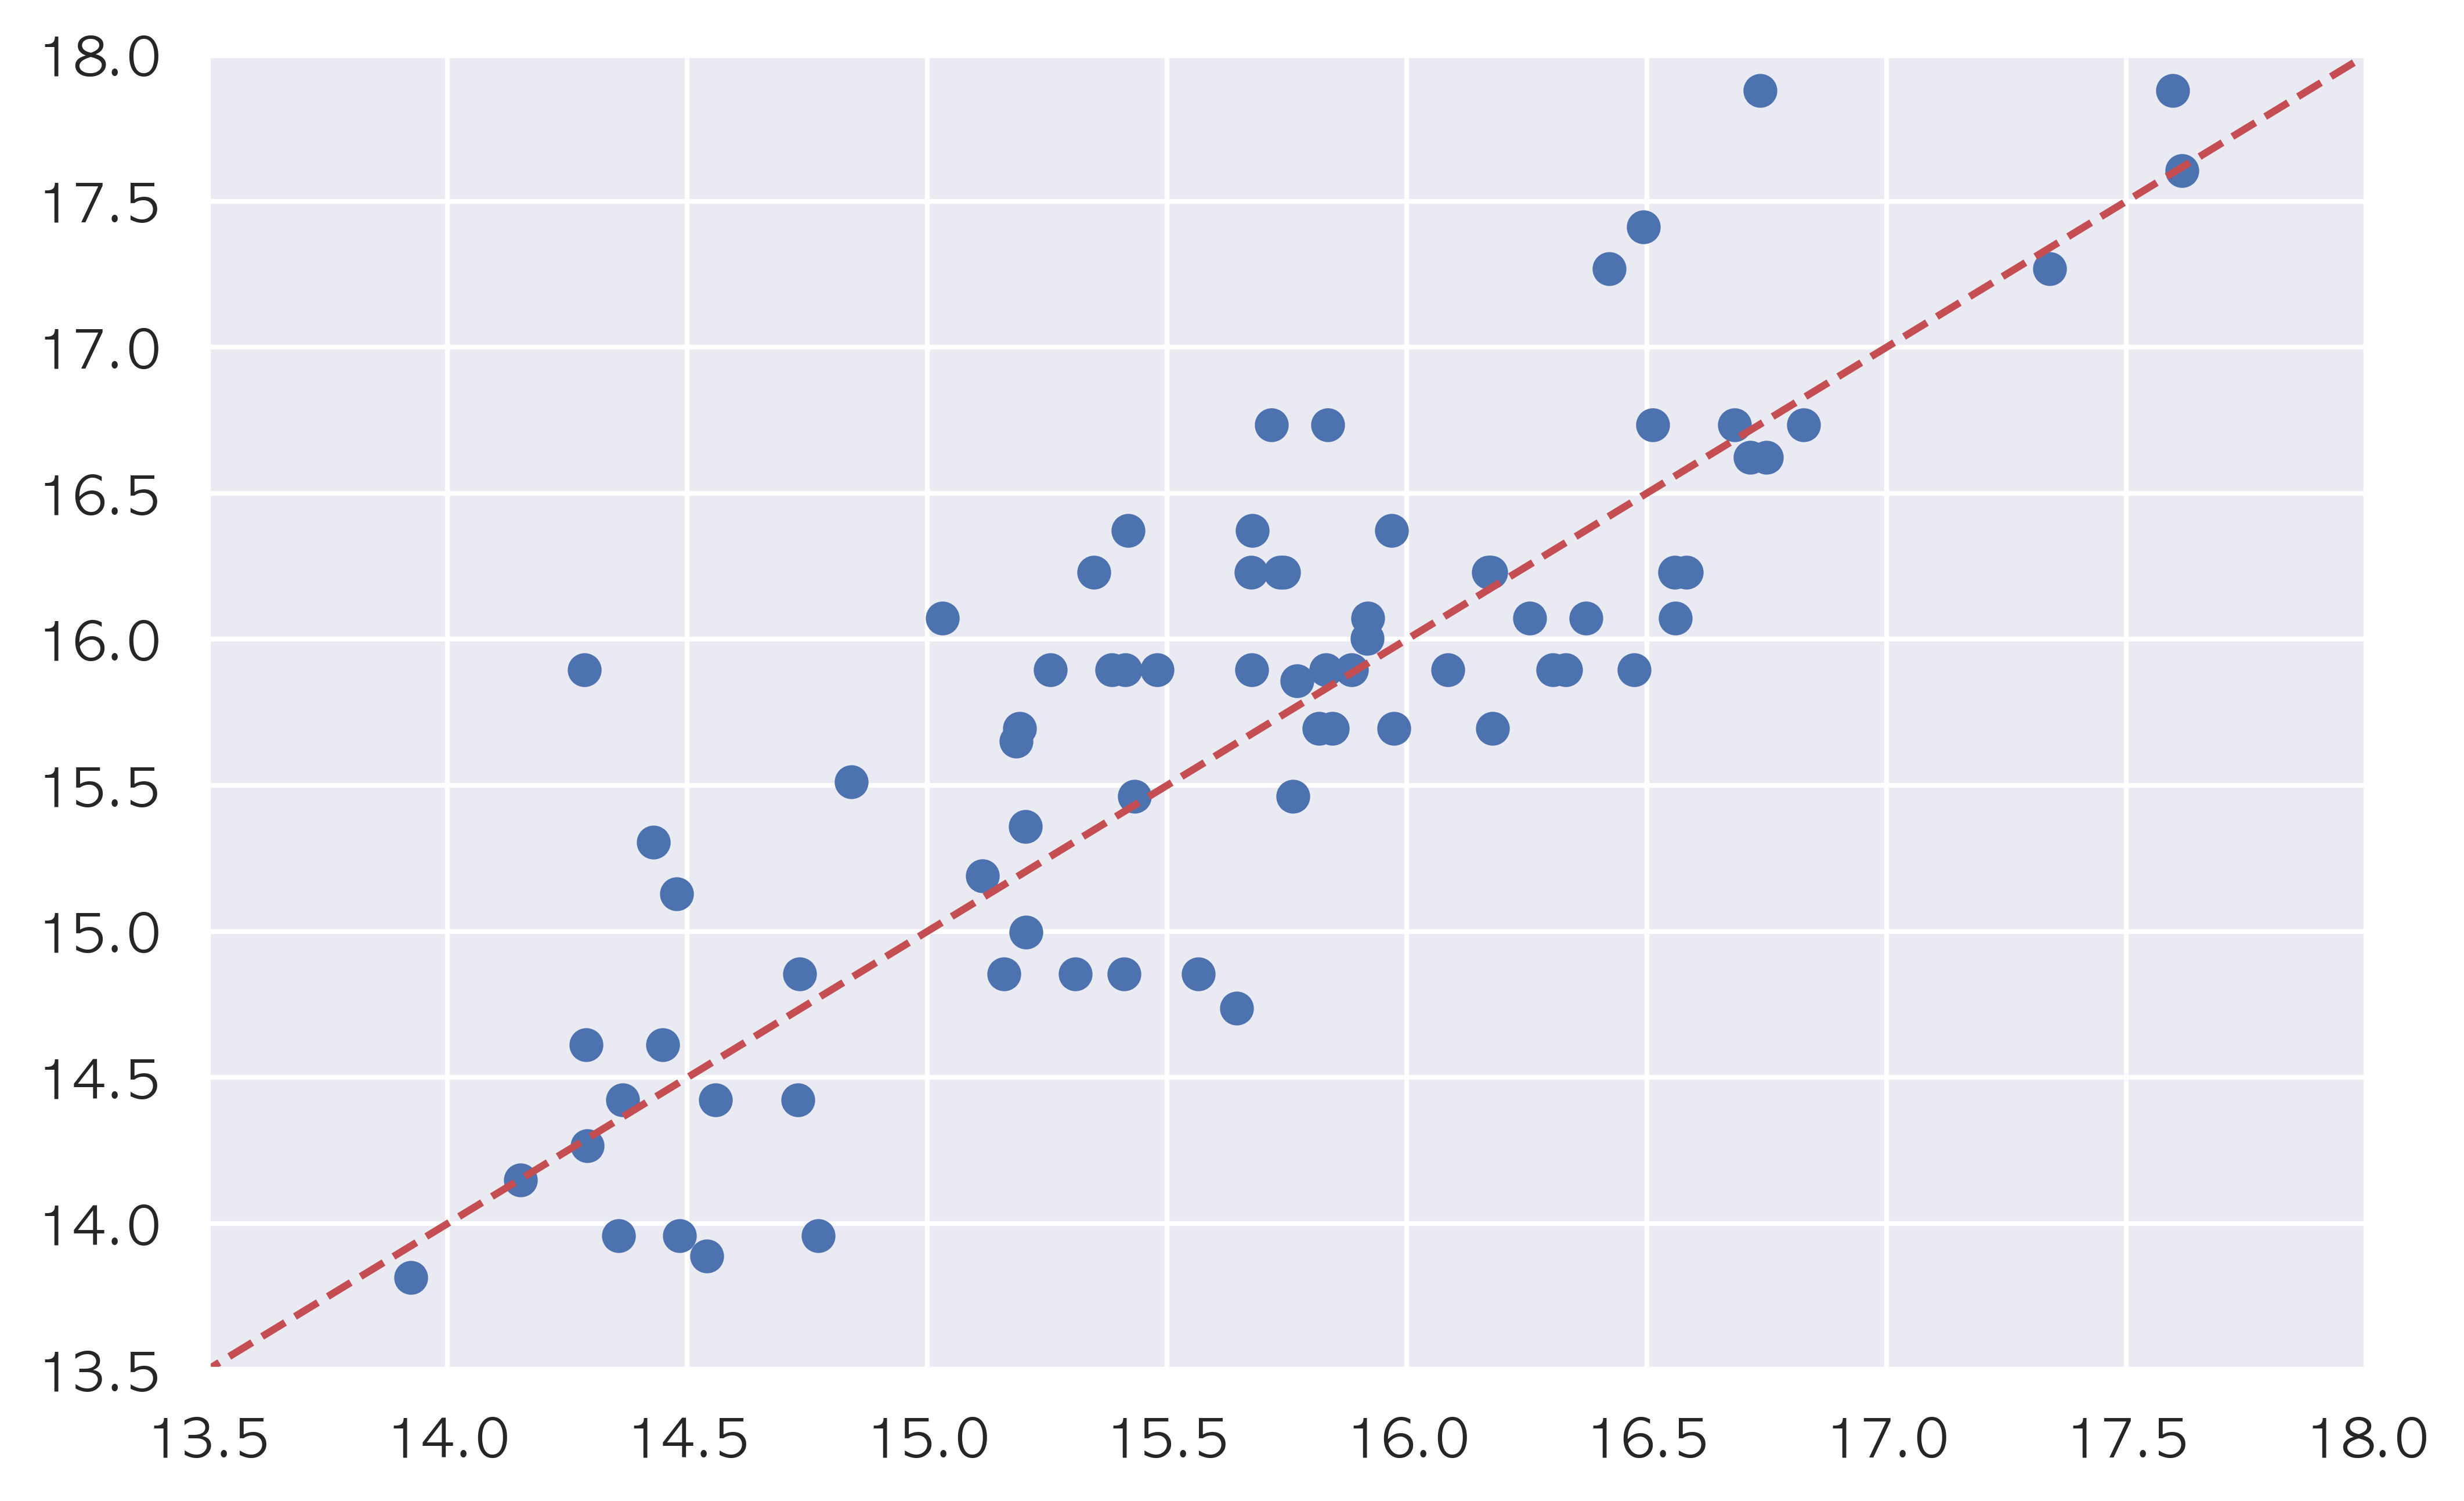

In [75]:
plt.scatter(pred, df_test['로그연봉'])
plt.plot([13, 19], [13, 19], ls='--', c='r')
plt.xlim(13.5, 18)
plt.ylim(13.5, 18)

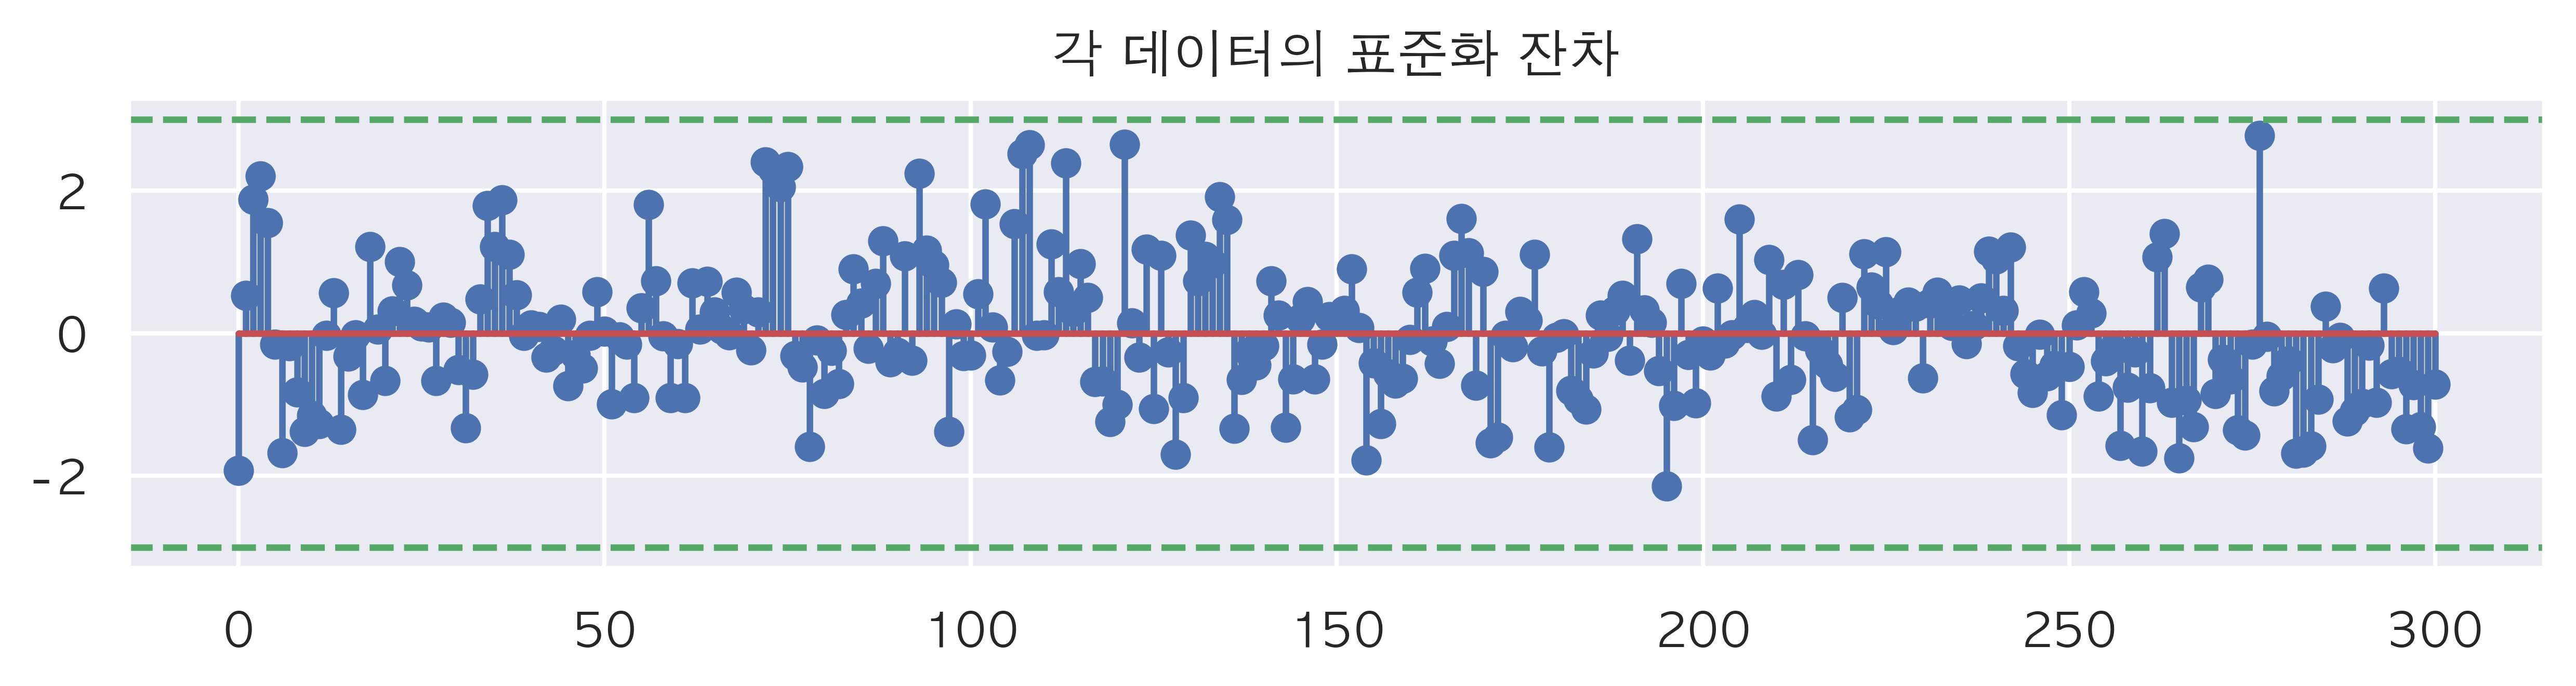

In [73]:
plt.figure(figsize=(10, 2))
plt.stem(result.resid_pearson)
plt.axhline(3, c="g", ls="--")
plt.axhline(-3, c="g", ls="--")
plt.title("각 데이터의 표준화 잔차")
plt.show()

## 아웃라이어 제거

### 1. 카테고리별 아웃라이어 파악

Text(0.5, 1.0, '시즌 카테고리별 연봉 violinplot')

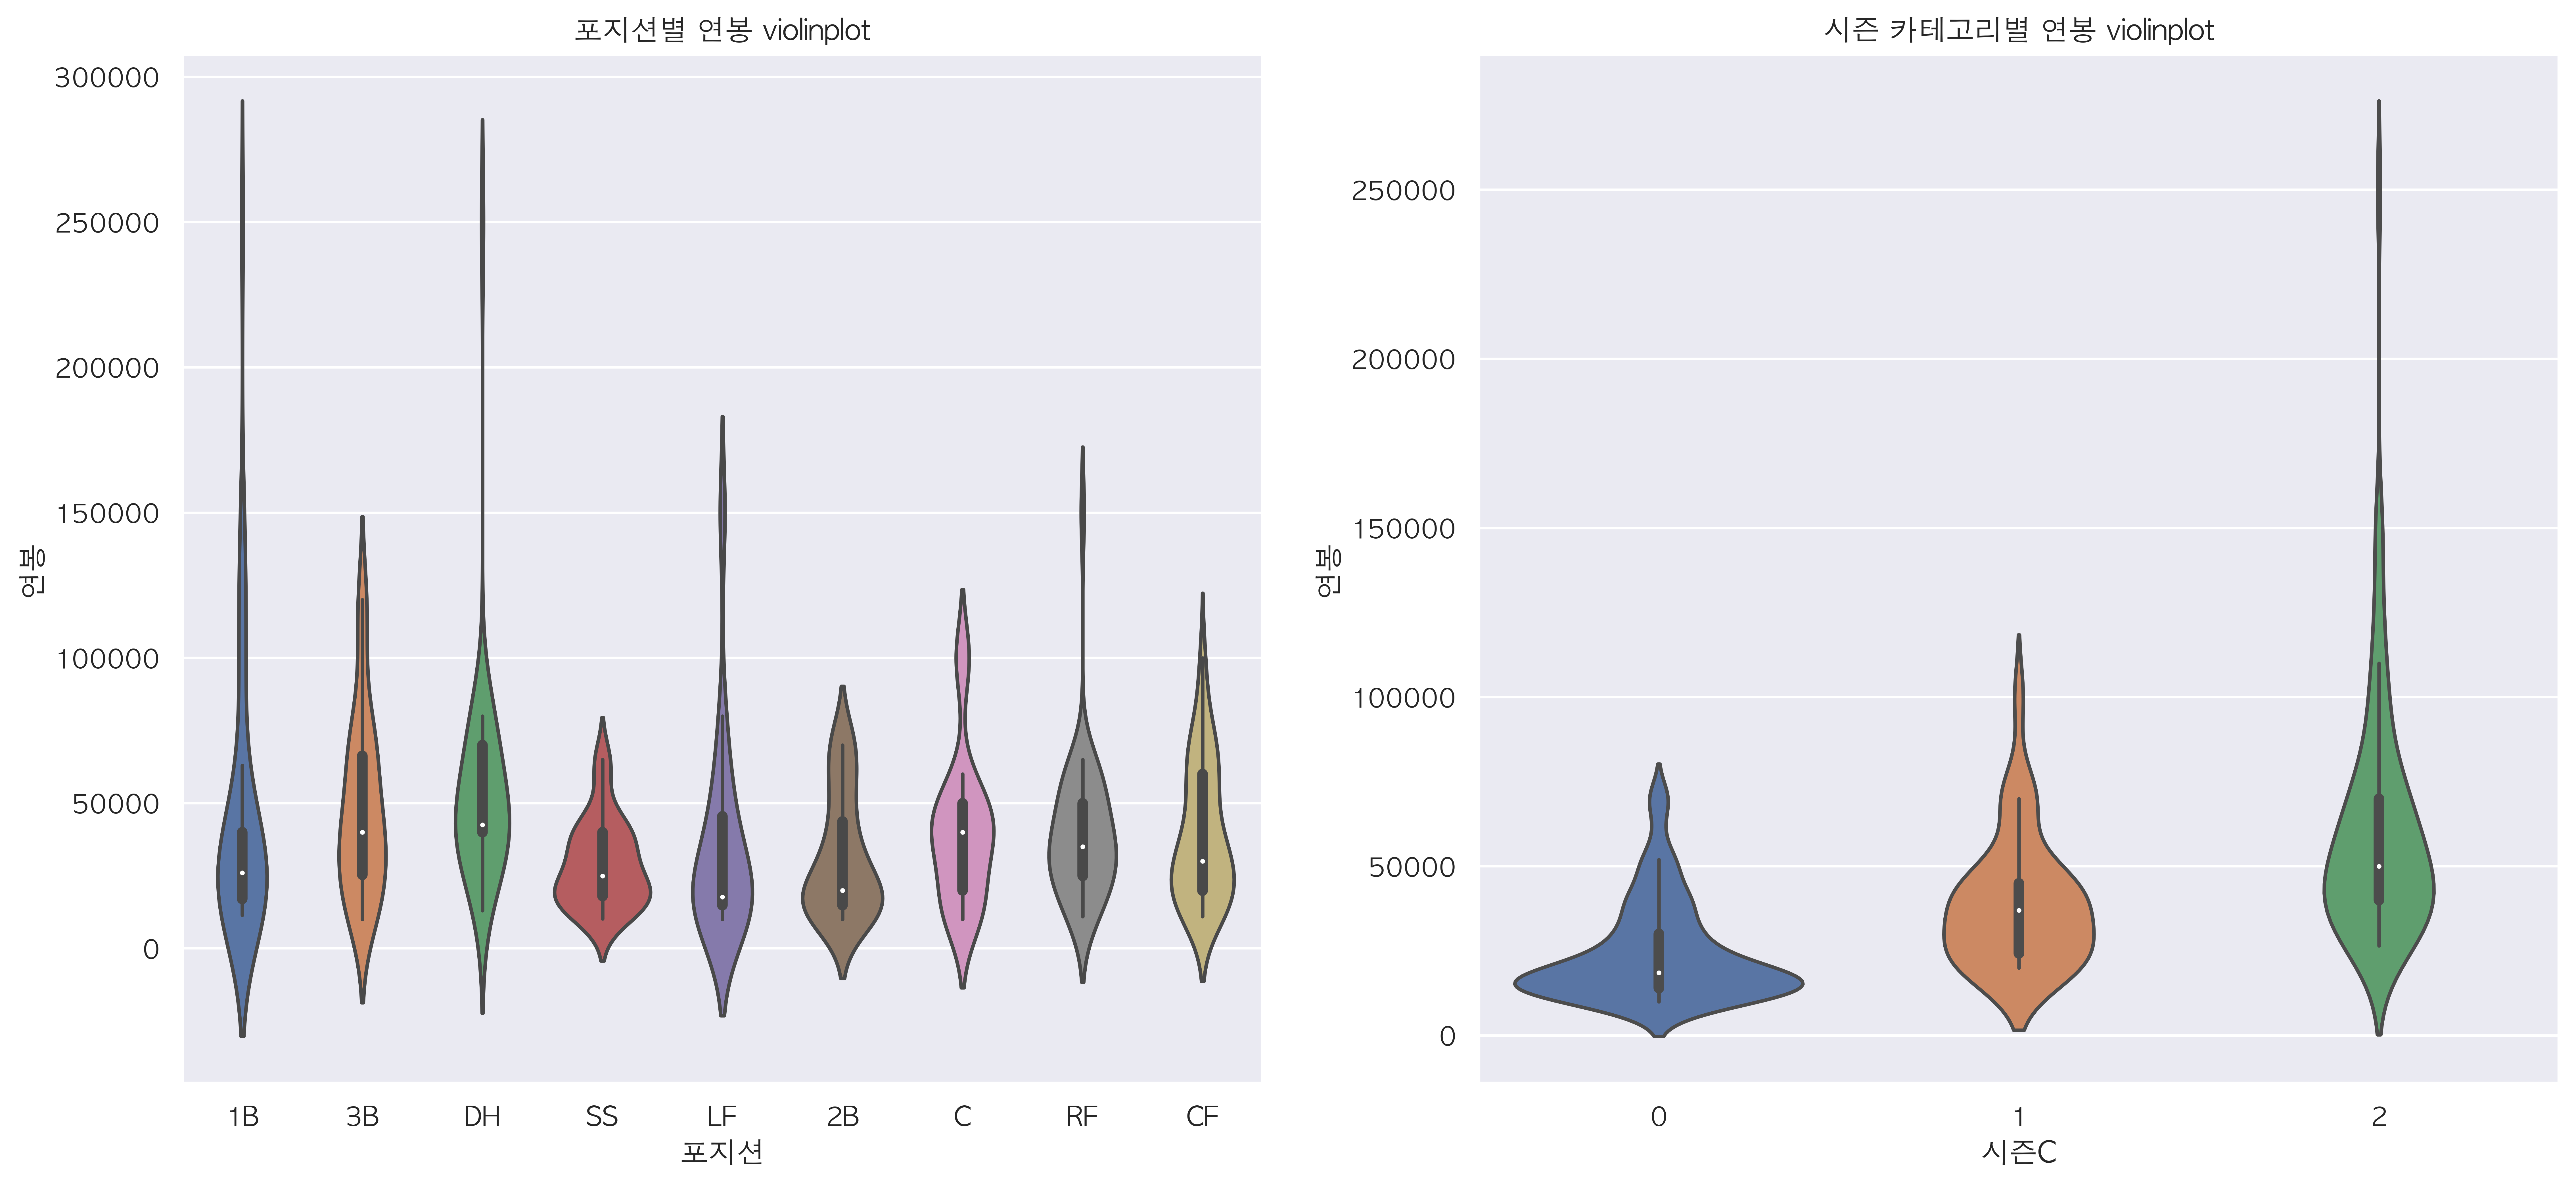

In [61]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.violinplot(x='포지션', y='연봉', data=df1, ax=ax[0])
ax[0].set_title("포지션별 연봉 violinplot")

sns.violinplot(x='시즌C', y='연봉', data=df1, ax=ax[1])
ax[1].set_title("시즌 카테고리별 연봉 violinplot")

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.violinplot(x='나이C', y='연봉', data=df, ax=ax[0])
ax[0].set_title("나이 카테고리 연봉 violinplot")

sns.violinplot(x='외국인', y='연봉', data=df, ax=ax[1])
ax[1].set_title("외국인 여부별 연봉 violinplot")

### 정리
- 1B과 DH에 아웃라이어가 큼
- 시즌 2015년 이후에 아웃라이어가 큼
- 26~37세 사이에 아웃라이어가 큼
- 외국인 중에는 아웃라이어가 없음

In [53]:
# 아웃라이어를 정리하기 위해 아웃라이어의 인덱스를 파악하는 코드


def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[column]
    quantile_20 = np.percentile(fraud.values, 20)
    quantile_80 = np.percentile(fraud.values, 80)

    iqr = quantile_80 - quantile_20
    iqr_weight = iqr * weight
    lowest_val = quantile_20 - iqr_weight
    highest_val = quantile_80 + iqr_weight

    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index

    return outlier_index

In [54]:
# 연봉 아웃라이어 인덱스 파악
get_outlier(df=df, column='연봉', weight=1.5)

Int64Index([214, 224, 564, 1235, 1240], dtype='int64')

In [46]:
# 19, 24 : 이대호
Lee_outlier_index = [19, 24]

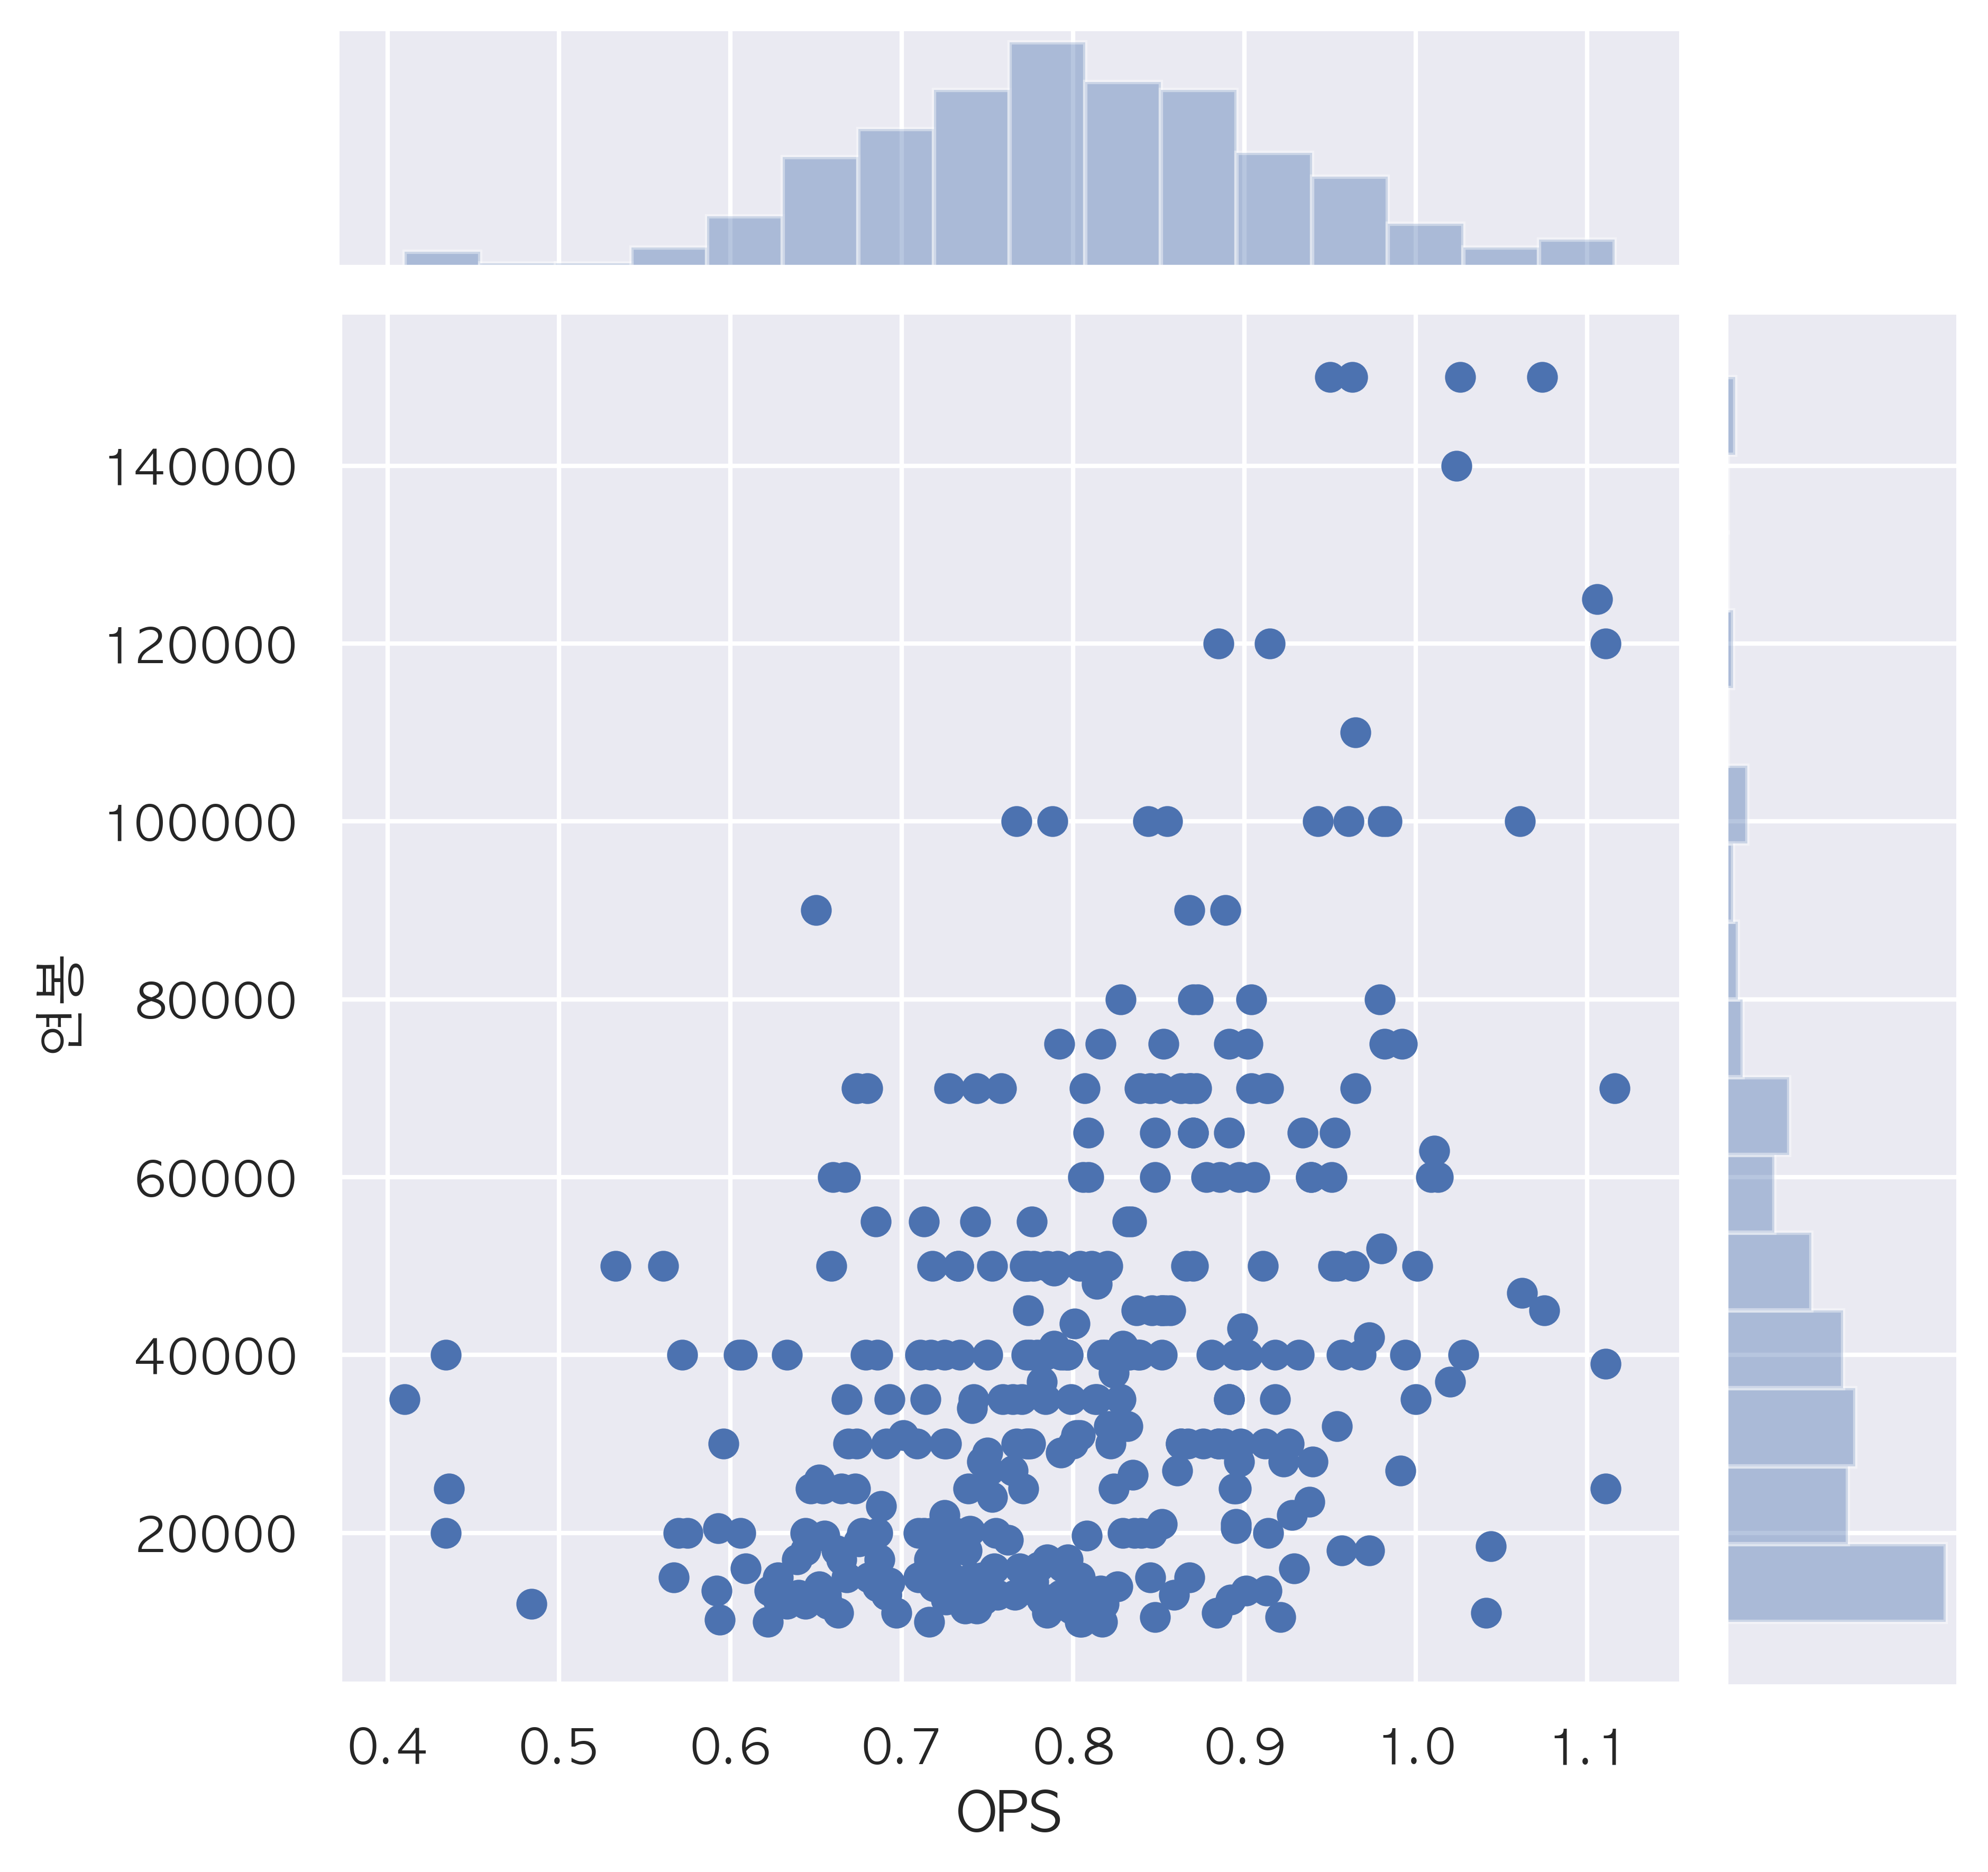

In [67]:
sns.jointplot(x='OPS', y='연봉', data=df)
plt.show()

In [62]:
df.shape

(356, 52)

In [63]:
outlier_index = get_outlier(df=df, column='OPS', weight=1.5)
df.drop(outlier_index, axis=0, inplace=True)
df.shape

(356, 52)

In [64]:
model = sm.OLS.from_formula(
    '로그연봉 ~ +C(포지션) + C(시즌C)+ C(나이C):scale(횟수) + scale(G) + scale(루타) + scale(도루) +scale(고4) + scale(타3) + C(외국인) + scale(BABIP) +scale(이적) + scale(ISOD) + scale(BBK) +scale(경험N)', data=df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   로그연봉   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     33.61
Date:                Sun, 05 Apr 2020   Prob (F-statistic):           3.54e-78
Time:                        12:31:43   Log-Likelihood:                -258.46
No. Observations:                 356   AIC:                             572.9
Df Residuals:                     328   BIC:                             681.4
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              15.0778    

Text(0.5, 1.0, '시즌 카테고리별 연봉 violinplot')

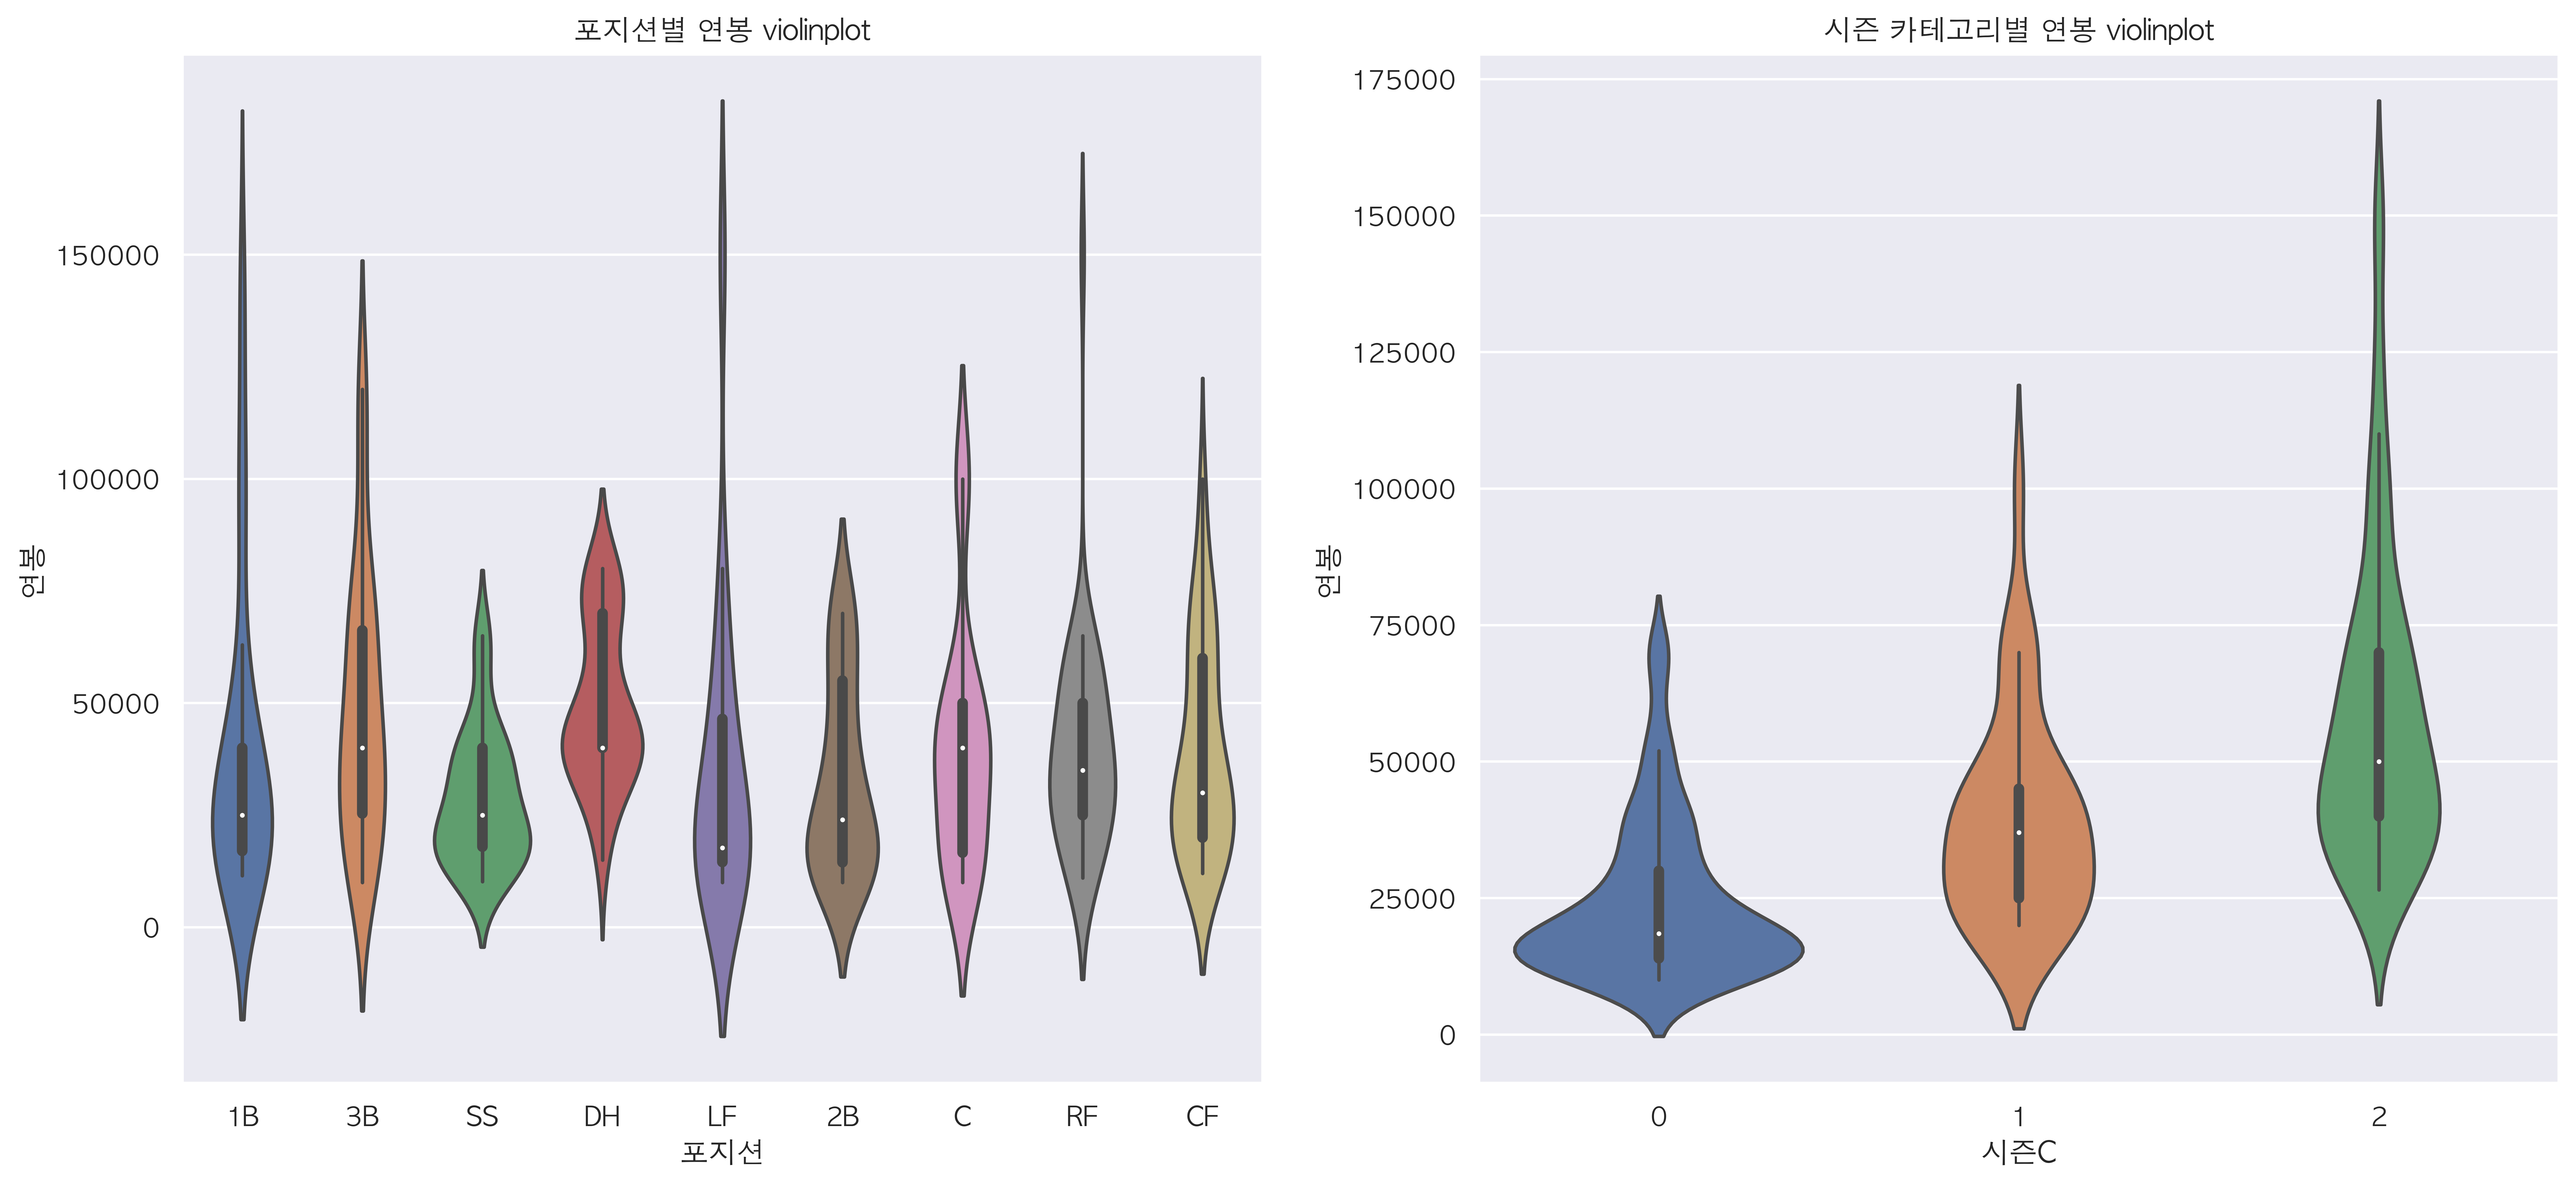

In [66]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.violinplot(x='포지션', y='연봉', data=df, ax=ax[0])
ax[0].set_title("포지션별 연봉 violinplot")

sns.violinplot(x='시즌C', y='연봉', data=df, ax=ax[1])
ax[1].set_title("시즌 카테고리별 연봉 violinplot")

### PCA

In [36]:
df.columns

Index(['ID', '이름', '시즌', '팀', '포지션', '나이', 'G', '타석', '타수', '득점', '안타', '타1',
       '타2', '타3', '홈런', '루타', '타점', '도루', '도실', '볼넷', '사구', '고4', '삼진', '병살',
       '희타', '희비', '타율', '출루', '장타', 'OPS', 'wOBA', 'wRC', 'twoBLUCK',
       'threeBLUCK', 'ISO', 'BBK', 'ISOD', '연봉', '횟수', '경험', '데뷔', '학력', '계약',
       '시즌C', '경험N', '외국인', 'BABIP', '이적', '이적C', '나이C', 'K', '로그연봉'],
      dtype='object')

```python
# 아웃라이어 제거
cooks_d2, pvals = influence.cooks_distance
K = influence.k_vars
fox_cr = 4 / (len(df['OPS']) - K - 1)
idx = np.where(cooks_d2 > fox_cr)[0]
idx2 = list(set(range(len(df))).difference(idx))
df1 = df.iloc[idx2, :].reset_index(drop=True)
```